<a href="https://colab.research.google.com/github/TomasVendel/ASESOR-FINANCIERO/blob/test-1/BOT_DE_TRADING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BOT DE TRADING PRUEBA N°1

In [ ]:
import requests
import pandas as pd
import time
import smtplib
from email.mime.text import MIMEText

# Tu clave de API de Alpha Vantage
alpha_vantage_key = 'AI9L6F2RL7EG7GJJ'  # Reemplazá con tu clave real

# Configuración del correo
correo_emisor = 'vendeltomas@gmail.com'  # Reemplazá con tu correo Gmail
contraseña = 'huqy zqif jbjm osah'  # Contraseña o contraseña de aplicación
correo_receptor = 'vendeltomasian@gmail.com'  # Reemplazá con el correo donde quieras recibir las señales


In [ ]:
# Obtener datos de EUR/USD cada 5 minutos
def obtener_datos():
    url = f'https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=5min&apikey={alpha_vantage_key}'
    response = requests.get(url)
    data = response.json()
    return data

# Calcular la media móvil simple
def calcular_sma(precios, periodos=8):
    return precios.rolling(window=periodos).mean()

# Generar señal de trading
def generar_senal(data):
    if 'Time Series FX (5min)' not in data:
        print("⚠️ Datos no disponibles o API sobrecargada.")
        return None

    try:
        serie = data['Time Series FX (5min)']
        precios = [float(serie[tiempo]['4. close']) for tiempo in sorted(serie.keys(), reverse=True)[:8]]
        precio_actual = precios[0]
        sma = calcular_sma(pd.Series(precios), periodos=8).iloc[-1]
        diferencia_pips = round((precio_actual - sma) * 10000, 2)

        print(f"Precio actual: {precio_actual}")
        print(f"SMA 8: {sma}")
        print(f"Diferencia en pips: {diferencia_pips}")

        if diferencia_pips > 10:
            return "VENDER"
        elif diferencia_pips < -10:
            return "COMPRAR"
        else:
            return None
    except Exception as e:
        print(f"Error al generar señal: {e}")
        return None


In [ ]:
# Enviar correo con la señal
def enviar_mail(mensaje):
    msg = MIMEText(mensaje)
    msg['Subject'] = 'Notificación del Bot de Trading'
    msg['From'] = correo_emisor
    msg['To'] = correo_receptor

    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as servidor:
            servidor.starttls()
            servidor.login(correo_emisor, contraseña)
            servidor.send_message(msg)
        print("📧 Correo enviado con éxito.")
    except Exception as e:
        print(f"❌ Error al enviar el correo: {e}")


In [ ]:
data = obtener_datos()
señal = generar_señal(data)

if señal:
    print(f"🔔 Señal: {señal}")
    enviar_mail(f"Bot de Trading: Señal = {señal}")
else:
    print("Sin señal válida. No se envía correo.")

PRUEBA N°2

In [ ]:
# ✅ Asistente de Inversiones + RSI en Google Sheets

import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials

# ---------------- FUNCIONES PRINCIPALES ----------------

def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")

def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")

def recomendar_portafolio(perfil, horizonte):
    if perfil == 1:
        return {'Renta fija': 70, 'Fondos comunes': 20, 'Cedears': 5, 'Criptomonedas': 5}
    elif perfil == 2:
        return {'Renta fija': 40, 'Acciones': 25, 'ETFs': 20, 'Criptomonedas': 15}
    else:
        return {'Acciones': 50, 'Criptomonedas': 25, 'ETFs': 15, 'Renta fija': 10}

def elegir_distribucion_personalizada():
    print("🔧 Ingresá tu distribución personalizada para los siguientes instrumentos: Renta fija, Acciones, ETFs y Criptomonedas. (Los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def mostrar_acciones_sobrevendidas_gs(json_file, sheet_url):
    try:
        scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
        credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file, scope)
        gc = gspread.authorize(credentials)
        spreadsheet = gc.open_by_url(sheet_url)
        worksheet = spreadsheet.sheet1
        df = get_as_dataframe(worksheet).dropna(how="all")
        df['RSI'] = pd.to_numeric(df['RSI'], errors='coerce')
        sobrevendidas = df[df['RSI'] < 30]

        if not sobrevendidas.empty:
            print("\n📉 Acciones en zona de sobreventa (RSI < 30):")
            print(sobrevendidas[['Símbolo', 'RSI']].to_string(index=False))
        else:
            print("\n✅ No hay acciones sobrevendidas según el RSI.")
    except Exception as e:
        print(f"❌ Error: {e}")

# ---------------- FUNCIÓN PRINCIPAL ----------------

def main():
    print("💸 Bienvenido al Asistente de Inversiones 💸")
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil, horizonte)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)

    if 'Acciones' in distribucion:
        ver_rsi = input("\n¿Querés ver acciones recomendadas por RSI desde Google Sheets? (s/n): ").lower()
        if ver_rsi == 's':
            json_file = input("Nombre del archivo JSON de credenciales (ej: credenciales.json): ")
            sheet_url = input("Pegá el link de tu Google Sheets: ")
            mostrar_acciones_sobrevendidas_gs(json_file, sheet_url)

    print("\n✅ Gracias por usar el asistente. ¡Éxitos con tus inversiones!")

# Ejecutar
main()


In [ ]:
# ✅ Asistente de Inversiones + RSI en Google Sheets

import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials


# ---------------- FUNCIONES PRINCIPALES ----------------

def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")

def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")

def recomendar_portafolio(perfil, horizonte):
    if perfil == 1:
        return {'Renta fija': 70, 'Fondos comunes': 20, 'Cedears': 5, 'Criptomonedas': 5}
    elif perfil == 2:
        return {'Renta fija': 40, 'Acciones': 25, 'ETFs': 20, 'Criptomonedas': 15}
    else:
        return {'Acciones': 50, 'Criptomonedas': 25, 'ETFs': 15, 'Renta fija': 10}

def elegir_distribucion_personalizada():
    print("🔧 Ingresá tu distribución personalizada para los siguientes instrumentos: Renta fija, Acciones, ETFs y Criptomonedas. (Los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def mostrar_acciones_sobrevendidas_gs(json_file, sheet_url):
    try:
        scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
        credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file, scope)
        gc = gspread.authorize(credentials)
        spreadsheet = gc.open_by_url(sheet_url)
        worksheet = spreadsheet.sheet1
        df = get_as_dataframe(worksheet).dropna(how="all")
        df['RSI'] = pd.to_numeric(df['RSI'], errors='coerce')
        sobrevendidas = df[df['RSI'] < 30].sort_values(by='RSI').head(10)

        if not sobrevendidas.empty:
            print("📉 Top 10 acciones en zona de sobreventa (RSI < 30):")
            print(sobrevendidas[['Símbolo', 'RSI']].to_string(index=False))
        else:
            print("✅ No hay acciones sobrevendidas según el RSI.")
    except Exception as e:
        print(f"❌ Error: {e}")
    except Exception as e:
        print(f"❌ Error: {e}")

# ---------------- FUNCIÓN PRINCIPAL ----------------

def main():
    print("💸 Bienvenido al Asistente de Inversiones 💸")
    while True:
        try:
            capital = float(input("¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil, horizonte)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)

    # Mostrar acciones con RSI bajo automáticamente
    json_file = "/content/proyecto-final-461615-9e35e553c57e (1).json"  # Cambiar por el nombre real del archivo JSON
    sheet_url = "https://www.google.com/finance/portfolio/09bfc014-75df-4cbf-93bd-a1c88d3bd2dc?authuser=0"  # URL definitiva del Google Sheets
    mostrar_acciones_sobrevendidas_gs(json_file, sheet_url)



    print("\n✅ Gracias por usar el asistente. ¡Éxitos con tus inversiones!")

# Ejecutar
main()


💸 Bienvenido al Asistente de Inversiones 💸
¿Cuánto capital tenés para invertir? $13300

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 1

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1
¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $9310.00 (70%)
- Fondos comunes: $2660.00 (20%)
- Cedears: $665.00 (5%)
- Criptomonedas: $665.00 (5%)
❌ Error: 

✅ Gracias por usar el asistente. ¡Éxitos con tus inversiones!


In [ ]:
# ✅ Asistente de Inversiones + RSI en Google Sheets

import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import files
import re # Import the re module for regular expressions

# ✅ Subir archivo JSON con las credenciales
print("📁 Subí tu archivo de credenciales (.json)")
uploaded = files.upload()
json_file = list(uploaded.keys())[0]  # nombre real del archivo subido

# ---------------- FUNCIONES PRINCIPALES ----------------

def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")

def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")

def recomendar_portafolio(perfil, horizonte):
    if perfil == 1:
        return {'Renta fija': 70, 'Fondos comunes': 20, 'Cedears': 5, 'Criptomonedas': 5}
    elif perfil == 2:
        return {'Renta fija': 40, 'Acciones': 25, 'ETFs': 20, 'Criptomonedas': 15}
    else:
        return {'Acciones': 50, 'Criptomonedas': 25, 'ETFs': 15, 'Renta fija': 10}

def elegir_distribucion_personalizada():
    print("🔧 Ingresá tu distribución personalizada para: Renta fija, Acciones, ETFs y Criptomonedas. (Deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

# Removed the redundant definition of mostrar_acciones_sobrevendidas_gs here

# ---------------- FUNCIÓN PRINCIPAL ----------------

def main():
    print("💸 Bienvenido al Asistente de Inversiones 💸")
    while True:
        try:
            capital = float(input("¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil, horizonte)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)

    # ✅ Mostrar acciones con RSI bajo
    # Ensure this function is correctly indented within main
    def mostrar_acciones_sobrevendidas_gs(json_file, sheet_url):
        try:
            import re
            # Corrected scope for read-only access
            scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive.readonly']
            credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file, scope)
            gc = gspread.authorize(credentials)

            spreadsheet = gc.open_by_url(sheet_url)
            # worksheet = spreadsheet.sheet1  # Usar la primera hoja - Removed as specific sheet is targeted

SyntaxError: incomplete input (<ipython-input-23-612842218b48>, line 121)

In [ ]:
# ✅ Asistente de Inversiones + RSI en Google Sheets

import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import files
import re # Import the re module for regular expressions

# ✅ Subir archivo JSON con las credenciales
print("📁 Subí tu archivo de credenciales (.json)")
uploaded = files.upload()
json_file = list(uploaded.keys())[0]  # nombre real del archivo subido

# ---------------- FUNCIONES PRINCIPALES ----------------

def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")

def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")

def recomendar_portafolio(perfil, horizonte):
    if perfil == 1:
        return {'Renta fija': 70, 'Fondos comunes': 20, 'Cedears': 5, 'Criptomonedas': 5}
    elif perfil == 2:
        return {'Renta fija': 40, 'Acciones': 25, 'ETFs': 20, 'Criptomonedas': 15}
    else:
        return {'Acciones': 50, 'Criptomonedas': 25, 'ETFs': 15, 'Renta fija': 10}

def elegir_distribucion_personalizada():
    print("🔧 Ingresá tu distribución personalizada para: Renta fija, Acciones, ETFs y Criptomonedas. (Deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

# Removed the redundant definition of mostrar_acciones_sobrevendidas_gs here

# ---------------- FUNCIÓN PRINCIPAL ----------------

def main():
    print("💸 Bienvenido al Asistente de Inversiones 💸")
    while True:
        try:
            capital = float(input("¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil, horizonte)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)

    # ✅ Mostrar acciones con RSI bajo
    # Ensure this function is correctly indented within main
    def mostrar_acciones_sobrevendidas_gs(json_file, sheet_url):
        try:
            import re
            # Corrected scope for read-only access
            scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive.readonly']
            credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file, scope)
            gc = gspread.authorize(credentials)

            spreadsheet = gc.open_by_url(sheet_url)
            # worksheet = spreadsheet.sheet1  # Usar la primera hoja - Removed as specific sheet is targeted below
            worksheet = spreadsheet.worksheet("USA")  # Asegurate que el nombre de la hoja sea correcto

            data = worksheet.get_all_values()

            tickers = []
            rsis = []

            for row in data:
                # Changed range to iterate through columns to find pairs
                for i in range(len(row) - 1):
                    ticker = row[i].strip()
                    rsi_val = row[i+1].strip()

                    # Verificamos que el RSI sea un número y el ticker sea una palabra (posiblemente símbolo)
                    # Corrected the regex patterns and used consistent quotes
                    if re.match(r'^[A-Z]{1,5}$', ticker) and re.match(r'^\d{1,3}(\.\d+)?$', rsi_val):
                        try:
                            rsi = float(rsi_val)
                            tickers.append(ticker)
                            rsis.append(rsi)
                        except ValueError:
                            # Handle cases where conversion to float fails for some reason
                            print(f"Skipping invalid RSI value: {rsi_val}")


            df = pd.DataFrame({'Símbolo': tickers, 'RSI': rsis})
            sobrevendidas = df[df['RSI'] < 30].sort_values(by='RSI').head(10)

            if not sobrevendidas.empty:
                print("\n📉 Top 10 acciones en zona de sobreventa (RSI < 30):")
                print(sobrevendidas[['Símbolo', 'RSI']].to_string(index=False))
            else:
                print("✅ No hay acciones sobrevendidas según el RSI.")
        except Exception as e:
            print(f"❌ Error al leer el Sheets: {e}")

    # Define json_file and sheet_url before calling the function
    # json_file is already defined from the file upload.
    sheet_url = "https://www.google.com/finance/portfolio/09bfc014-75df-4cbf-93bd-a1c88d3bd2dc?authuser=0"  # URL definitiva del Google Sheets

    # Call the nested function to display the data
    mostrar_acciones_sobrevendidas_gs(json_file, sheet_url)

    print("\n✅ Gracias por usar el asistente. ¡Éxitos con tus inversiones!")

# Ejecutar
main()

📁 Subí tu archivo de credenciales (.json)


Saving proyecto-final-461615-9e35e553c57e.json to proyecto-final-461615-9e35e553c57e (4).json
💸 Bienvenido al Asistente de Inversiones 💸
¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1
¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Acciones: $500.00 (50%)
- Criptomonedas: $250.00 (25%)
- ETFs: $150.00 (15%)
- Renta fija: $100.00 (10%)
❌ Error al leer el Sheets: 

✅ Gracias por usar el asistente. ¡Éxitos con tus inversiones!


In [ ]:
# ✅ Asistente de Inversiones Profesional con APIs Reales (Alpha Vantage + CoinGecko)

import requests
import pandas as pd
import time

# ---------------- CONFIGURACIÓN ----------------

# 💡 Alpha Vantage (acciones y ETFs)
ALPHA_VANTAGE_API_KEY = "0O65J7BRCUA3SOE9"

# 💡 CoinGecko no necesita API Key (gratuito)

# ---------------- FUNCIONES DE INTERFAZ ----------------

def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")

def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")

def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    print("\n🔧 Ingresá tu distribución personalizada para los siguientes instrumentos: Renta fija, Acciones, ETFs y Criptomonedas (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

# ---------------- RECOMENDACIONES DINÁMICAS ----------------

def recomendar_acciones():
    print("\n📈 Acciones sugeridas (RSI bajo - oportunidad de compra):")
    simbolos = ["AAPL", "MSFT", "TSLA", "GOOGL", "NVDA"]
    recomendaciones = []
    for simbolo in simbolos:
        url = f"https://www.alphavantage.co/query?function=RSI&symbol={simbolo}&interval=daily&time_period=14&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
        r = requests.get(url)
        data = r.json()
        try:
            rsi_series = data['Technical Analysis: RSI']
            ultimo_rsi = float(list(rsi_series.values())[0]['RSI'])
            if ultimo_rsi < 35:
                recomendaciones.append((simbolo, round(ultimo_rsi, 2)))
        except:
            continue
        time.sleep(12)  # Para evitar límites de Alpha Vantage (5 llamadas por minuto)

    if recomendaciones:
        for s, r in recomendaciones:
            print(f"- {s}: RSI {r}")
    else:
        print("No hay acciones con RSI bajo en este momento.")

def recomendar_criptos():
    print("\n💰 Criptomonedas sugeridas (top bajistas para oportunidad):")
    url = "https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=percent_change_24h_asc&per_page=5&page=1&sparkline=false"
    data = requests.get(url).json()
    for cripto in data:
        print(f"- {cripto['name']} ({cripto['symbol'].upper()}): {cripto['price_change_percentage_24h']:.2f}% hoy")

def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos del Tesoro USA (ETF: BND o TLT)")
    print("- Bonos soberanos AR en USD: AL30, GD30")

def recomendar_etfs():
    print("\n🌍 ETFs sugeridos:")
    print("- SPY (S&P 500)")
    print("- QQQ (Nasdaq)")
    print("- VTI (Total Market)")

# ---------------- FUNCIÓN PRINCIPAL ----------------

def main():
    print("💸 Bienvenido al Asistente de Inversiones 💸")

    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)

    if distribucion.get("Acciones", 0) > 0:
        recomendar_acciones()
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Éxitos con tus inversiones!")

# Ejecutar
main()


💸 Bienvenido al Asistente de Inversiones 💸

¿Cuánto capital tenés para invertir? $10000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 1

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 3

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $6000.00 (60%)
- Acciones: $2000.00 (20%)
- ETFs: $1000.00 (10%)
- Criptomonedas: $1000.00 (10%)

📈 Acciones sugeridas (RSI bajo - oportunidad de compra):
No hay acciones con RSI bajo en este momento.

💰 Criptomonedas sugeridas (top bajistas para oportunidad):
- Bitcoin (BTC): 0.99% hoy
- Ethereum (ETH): 0.18% hoy
- Tether (USDT): -0.00% hoy
- XRP (XRP): -0.02% hoy
- BNB (BNB): 0.45% hoy

🏦 Renta fija sugerida:
- Bonos del Tesoro USA (ETF: BND o TL

In [ ]:
import requests

# 👇 Pegá tu API Key de Alpha Vantage acá:
ALPHA_VANTAGE_API_KEY = "ACA_TU_API_KEY"

# 🔎 Lista de acciones sugeridas (puedes ampliarla)
acciones_para_analizar = ["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN"]

# 🧠 Función para calcular RSI usando Alpha Vantage
def obtener_rsi(symbol):
    url = (
        f"https://www.alphavantage.co/query?function=RSI&symbol={symbol}"
        f"&interval=daily&time_period=14&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
    )
    try:
        response = requests.get(url)
        data = response.json()
        rsi_data = data["Technical Analysis: RSI"]
        rsi_valor = float(next(iter(rsi_data.values()))["RSI"])
        return rsi_valor
    except:
        return None

# 🪙 Función para obtener precios de criptomonedas desde CoinGecko
def obtener_precio_crypto(nombre_id):
    url = f"https://api.coingecko.com/api/v3/simple/price?ids={nombre_id}&vs_currencies=usd"
    try:
        response = requests.get(url)
        return response.json()[nombre_id]["usd"]
    except:
        return None

# 🎯 Función para mostrar sugerencias de acciones (RSI < 30 es oportunidad de compra)
def sugerir_acciones():
    sugeridas = []
    for ticker in acciones_para_analizar:
        rsi = obtener_rsi(ticker)
        if rsi and rsi < 30:
            sugeridas.append((ticker, rsi))
    return sugeridas

# 🧑‍💼 Inicio del programa
print("\U0001F4CA Bienvenido al Asistente de Inversiones \U0001F4CA")

capital = float(input("¿Cuánto capital tenés para invertir? $"))

print("\n¿Qué tipo de inversor sos?")
print("1 - Conservador\n2 - Moderado\n3 - Agresivo")
perfil = int(input("Elegí una opción (1/2/3): "))

print("\n¿Cuál es tu horizonte de inversión?")
print("1 - Corto plazo (0-12 meses)\n2 - Mediano plazo (1-3 años)\n3 - Largo plazo (más de 3 años)")
plazo = int(input("Elegí una opción (1/2/3): "))

print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
print("1 - Usar distribución sugerida\n2 - Crear mi propia distribución")
modo = int(input("Elegí una opción (1/2): "))

if modo == 1:
    if perfil == 1:
        dist = {"Renta fija": 0.7, "Acciones": 0.1, "ETFs": 0.1, "Criptomonedas": 0.1}
    elif perfil == 2:
        dist = {"Renta fija": 0.3, "Acciones": 0.4, "ETFs": 0.2, "Criptomonedas": 0.1}
    else:
        dist = {"Renta fija": 0.1, "Acciones": 0.5, "ETFs": 0.2, "Criptomonedas": 0.2}
else:
    dist = {}
    for tipo in ["Renta fija", "Acciones", "ETFs", "Criptomonedas"]:
        porcentaje = float(input(f"¿Qué porcentaje (%) querés invertir en {tipo}? ")) / 100
        dist[tipo] = porcentaje

# 💾 Mostrar distribución
print("\n📋 Distribución seleccionada:")
for tipo, porc in dist.items():
    monto = capital * porc
    print(f"{tipo}: ${monto:.2f} ({porc*100:.0f}%)")

# ✅ Mostrar sugerencias de acciones
print("\n📌 Acciones sugeridas (RSI bajo = oportunidad de compra):")
sugerencias = sugerir_acciones()
if sugerencias:
    for ticker, rsi in sugerencias:
        print(f"- {ticker} (RSI: {rsi:.2f})")
else:
    print("No se detectaron acciones con RSI menor a 30.")

# 💸 Mostrar precios actuales de criptomonedas más populares
print("\n💰 Precios actuales de criptomonedas (CoinGecko):")
for crypto in ["bitcoin", "ethereum", "solana"]:
    precio = obtener_precio_crypto(crypto)
    if precio:
        print(f"- {crypto.capitalize()}: ${precio}")


📊 Bienvenido al Asistente de Inversiones 📊
¿Cuánto capital tenés para invertir? $10000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📋 Distribución seleccionada:
Renta fija: $1000.00 (10%)
Acciones: $5000.00 (50%)
ETFs: $2000.00 (20%)
Criptomonedas: $2000.00 (20%)

📌 Acciones sugeridas (RSI bajo = oportunidad de compra):
No se detectaron acciones con RSI menor a 30.

💰 Precios actuales de criptomonedas (CoinGecko):
- Bitcoin: $105804
- Ethereum: $2541.04
- Solana: $157.4


💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital querés invertir? $10000

📌 ¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

⏳ ¿Cuál es tu horizonte de inversión?
1 - Corto plazo
2 - Mediano plazo
3 - Largo plazo
Elegí una opción (1/2/3): 1

🎯 Tu portafolio sugerido:
- Renta fija: 10% ($1000.00)
- Acciones: 50% ($5000.00)
- ETFs: 20% ($2000.00)
- Criptomonedas: 20% ($2000.00)


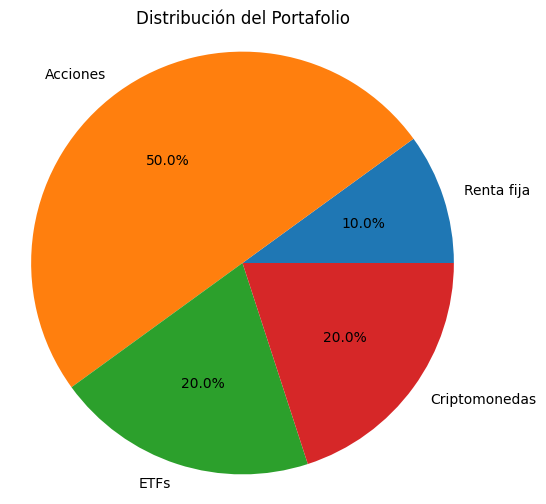


🌍 ¿Querés invertir en acciones de qué región?
1 - Estados Unidos
2 - Resto del mundo (Argentina)
Elegí una opción (1/2): 1

📈 Acciones recomendadas con RSI bajo:

💰 Criptomonedas sugeridas (más bajistas hoy):
- Bitcoin (BTC): 1.08% hoy
- Ethereum (ETH): 0.48% hoy
- Tether (USDT): 0.00% hoy
- XRP (XRP): 0.31% hoy
- BNB (BNB): 0.55% hoy

🏦 Renta fija sugerida:
- Bonos USA: ETF BND o TLT
- Bonos AR en USD: AL30, GD30

🌍 ETFs sugeridos:
- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)

✅ Fin del análisis. ¡Gracias por usar el asistente!


In [ ]:
import requests
import time
import matplotlib.pyplot as plt

# API Keys
ALPHA_VANTAGE_API_KEY = "TU_API_KEY"  # Reemplazá con la tuya

# Listado amplio de acciones
acciones_usa = ["AAPL", "MSFT", "TSLA", "GOOGL", "NVDA", "AMZN", "META", "JPM", "V", "UNH"]
acciones_globales = ["GGAL.BA", "YPF.BA", "SUPV.BA", "BMA.BA", "CEPU.BA"]

# --------------------- FUNCIONES ---------------------

def obtener_perfil():
    print("\n📌 ¿Qué tipo de inversor sos?")
    print("1 - Conservador\n2 - Moderado\n3 - Agresivo")
    return int(input("Elegí una opción (1/2/3): "))

def obtener_horizonte():
    print("\n⏳ ¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo\n2 - Mediano plazo\n3 - Largo plazo")
    return int(input("Elegí una opción (1/2/3): "))

def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def graficar_distribucion(portafolio):
    labels = list(portafolio.keys())
    sizes = list(portafolio.values())
    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title("Distribución del Portafolio")
    plt.axis('equal')
    plt.show()

def seleccionar_region():
    print("\n🌍 ¿Querés invertir en acciones de qué región?")
    print("1 - Estados Unidos\n2 - Resto del mundo (Argentina)")
    return int(input("Elegí una opción (1/2): "))

def calcular_indicadores(simbolo):
    try:
        # RSI
        url_rsi = f"https://www.alphavantage.co/query?function=RSI&symbol={simbolo}&interval=daily&time_period=14&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
        rsi_data = requests.get(url_rsi).json()
        rsi = float(list(rsi_data['Technical Analysis: RSI'].values())[0]['RSI'])

        # MACD
        url_macd = f"https://www.alphavantage.co/query?function=MACD&symbol={simbolo}&interval=daily&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
        macd_data = requests.get(url_macd).json()
        valores = list(macd_data["Technical Analysis: MACD"].values())[0]
        macd = float(valores["MACD"])
        signal = float(valores["MACD_Signal"])
        hist = float(valores["MACD_Hist"])

        return rsi, macd, signal, hist
    except:
        return None

def interpretar_recomendacion(rsi, macd, signal):
    if rsi < 30 and macd > signal:
        return "✅ Entrar ahora"
    elif 30 <= rsi <= 70:
        return "⏳ Esperar corrección"
    elif rsi > 70:
        return "⚠️ Sobrecomprado"
    return "❔ Sin datos"

def recomendar_acciones(region):
    print("\n📈 Acciones recomendadas con RSI bajo:")
    lista = acciones_usa if region == 1 else acciones_globales
    resultados = []

    for simbolo in lista:
        datos = calcular_indicadores(simbolo)
        if datos:
            rsi, macd, signal, hist = datos
            recomendacion = interpretar_recomendacion(rsi, macd, signal)
            resultados.append((simbolo, rsi, macd, recomendacion))
            time.sleep(12)  # Alpha Vantage rate limit

    resultados.sort(key=lambda x: x[1])  # Ordenar por RSI
    top = resultados[:5]

    for simbolo, rsi, macd, rec in top:
        print(f"- {simbolo}: RSI {rsi:.2f} | MACD {macd:.2f} -> {rec}")

def recomendar_criptos():
    print("\n💰 Criptomonedas sugeridas (más bajistas hoy):")
    url = "https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=percent_change_24h_asc&per_page=5&page=1"
    data = requests.get(url).json()
    for cripto in data:
        print(f"- {cripto['name']} ({cripto['symbol'].upper()}): {cripto['price_change_percentage_24h']:.2f}% hoy")

def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")

def recomendar_etfs():
    print("\n🌍 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")

# --------------------- PROGRAMA PRINCIPAL ---------------------

def main():
    print("💸 Bienvenido al Asistente de Inversiones Profesional 💸")
    capital = float(input("\n¿Cuánto capital querés invertir? $"))
    perfil = obtener_perfil()
    horizonte = obtener_horizonte()
    portafolio = recomendar_portafolio(perfil)

    print("\n🎯 Tu portafolio sugerido:")
    for k, v in portafolio.items():
        print(f"- {k}: {v}% (${capital*v/100:.2f})")

    graficar_distribucion(portafolio)

    region = seleccionar_region()

    if portafolio.get("Acciones", 0) > 0:
        recomendar_acciones(region)
    if portafolio.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if portafolio.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if portafolio.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Fin del análisis. ¡Gracias por usar el asistente!")

# Ejecutar
main()


💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


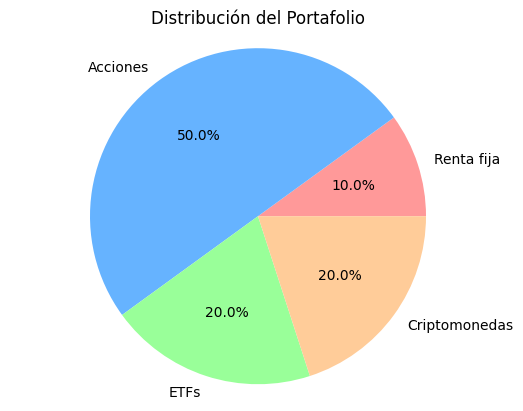


🟢 ¿Querés invertir en acciones de qué región?
1 - Estados Unidos
2 - Resto del mundo (Argentina)
Elegí una opción (1/2): 1

📌 Acciones recomendadas con RSI bajo y análisis MACD:
- AAPL: ❌ No se pudo obtener info
- TSLA: ❌ No se pudo obtener info
- NVDA: ❌ No se pudo obtener info
- MSFT: ❌ No se pudo obtener info
- GOOGL: ❌ No se pudo obtener info

🪙 Criptomonedas sugeridas (más bajistas hoy):
- Bitcoin (BTC): -0.53% hoy
- Ethereum (ETH): 0.53% hoy
- Tether (USDT): -0.00% hoy
- XRP (XRP): 0.07% hoy
- BNB (BNB): 0.30% hoy

🏦 Renta fija sugerida:
- Bonos USA: ETF BND o TLT
- Bonos AR en USD: AL30, GD30

🌐 ETFs sugeridos:
- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)

✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!


In [ ]:
# 💸 Asistente de Inversiones Profesional con API Alpha Vantage + CoinGecko

import requests
import pandas as pd
import matplotlib.pyplot as plt
import time

# ---------------- CONFIGURACIÓN ----------------

ALPHA_VANTAGE_API_KEY = "YNRF8O89RCN3GW3R"  # Reemplaza con tu propia API Key si lo deseas

# ---------------- FUNCIONES DE INTERFAZ ----------------

def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")

def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")

def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

# ---------------- RECOMENDACIONES ----------------

def recomendar_acciones(region="USA"):
    print("\n🟢 ¿Querés invertir en acciones de qué región?")
    print("1 - Estados Unidos")
    print("2 - Resto del mundo (Argentina)")
    opcion = input("Elegí una opción (1/2): ")
    if opcion == "2":
        print("\n📈 Recomendación: CEDEARs de empresas sólidas (GGAL, YPF, MELI)")
        return

    print("\n📌 Acciones recomendadas con RSI bajo y análisis MACD:")
    simbolos = ["AAPL", "TSLA", "NVDA", "MSFT", "GOOGL"]
    for simbolo in simbolos:
        rsi_url = f"https://www.alphavantage.co/query?function=RSI&symbol={simbolo}&interval=daily&time_period=14&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
        macd_url = f"https://www.alphavantage.co/query?function=MACD&symbol={simbolo}&interval=daily&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"

        try:
            rsi_data = requests.get(rsi_url).json()
            rsi = float(list(rsi_data['Technical Analysis: RSI'].values())[0]['RSI'])

            macd_data = requests.get(macd_url).json()
            macd_valores = list(macd_data['Technical Analysis: MACD'].values())[0]
            macd = float(macd_valores['MACD'])
            signal = float(macd_valores['MACD_Signal'])

            # Interpretación
            if rsi < 30:
                decision = "📉 Muy sobrevendida - Entrar ahora"
            elif rsi < 50:
                decision = "⏳ RSI moderado - Esperar corrección"
            else:
                decision = "⚠️ RSI alto - Sobrecomprado"

            print(f"- {simbolo}: RSI={rsi:.2f}, MACD={macd:.2f}, Señal={signal:.2f} → {decision}")
        except:
            print(f"- {simbolo}: ❌ No se pudo obtener info")
        time.sleep(12)

def recomendar_criptos():
    print("\n🪙 Criptomonedas sugeridas (más bajistas hoy):")
    url = "https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=percent_change_24h_asc&per_page=5&page=1&sparkline=false"
    data = requests.get(url).json()
    for cripto in data:
        print(f"- {cripto['name']} ({cripto['symbol'].upper()}): {cripto['price_change_percentage_24h']:.2f}% hoy")

def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")

def recomendar_etfs():
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")

# ---------------- FUNCIÓN PRINCIPAL ----------------

def main():
    print("💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    if distribucion.get("Acciones", 0) > 0:
        recomendar_acciones()
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")

# Ejecutar
main()


💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 1

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 3

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $600.00 (60%)
- Acciones: $200.00 (20%)
- ETFs: $100.00 (10%)
- Criptomonedas: $100.00 (10%)


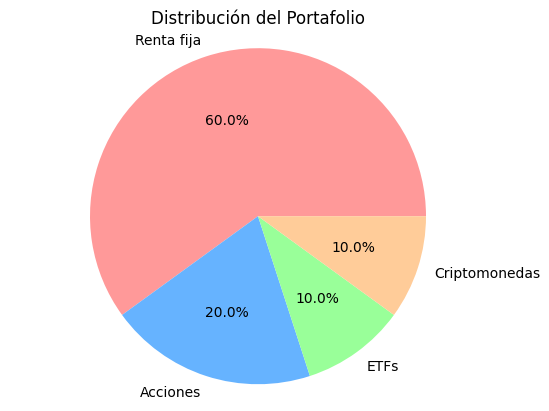


🟢 ¿Querés invertir en acciones de qué región?
1 - Estados Unidos
2 - Resto del mundo (Argentina)
Elegí una opción (1/2): 1

📌 Acciones recomendadas con RSI y MACD:
- AAPL: ❌ No se pudo obtener info (MACD no disponible)
- TSLA: ❌ No se pudo obtener info (MACD no disponible)
- NVDA: ❌ No se pudo obtener info (MACD no disponible)
- MSFT: ❌ No se pudo obtener info (MACD no disponible)
- GOOGL: ❌ No se pudo obtener info (MACD no disponible)

🪙 Criptomonedas sugeridas (más bajistas hoy):
- Bitcoin (BTC): -0.01% hoy
- Ethereum (ETH): 2.04% hoy
- Tether (USDT): -0.00% hoy
- XRP (XRP): 0.56% hoy
- BNB (BNB): 0.65% hoy

🏦 Renta fija sugerida:
- Bonos USA: ETF BND o TLT
- Bonos AR en USD: AL30, GD30

🌐 ETFs sugeridos:
- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)

✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!


In [ ]:
# 💸 Asistente de Inversiones Profesional mejorado
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time

ALPHA_VANTAGE_API_KEY = "YNRF8O89RCN3GW3R"

def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")

def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")

def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def recomendar_acciones(region="USA"):
    print("\n🟢 ¿Querés invertir en acciones de qué región?")
    print("1 - Estados Unidos")
    print("2 - Resto del mundo (Argentina)")
    opcion = input("Elegí una opción (1/2): ")
    if opcion == "2":
        print("\n📈 Recomendación: CEDEARs de empresas sólidas (GGAL, YPF, MELI)")
        return

    print("\n📌 Acciones recomendadas con RSI y MACD:")
    simbolos = ["AAPL", "TSLA", "NVDA", "MSFT", "GOOGL"]
    for simbolo in simbolos:
        try:
            rsi_url = f"https://www.alphavantage.co/query?function=RSI&symbol={simbolo}&interval=daily&time_period=14&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
            rsi_resp = requests.get(rsi_url)
            rsi_data = rsi_resp.json()
            if "Technical Analysis: RSI" not in rsi_data:
                raise ValueError("RSI no disponible")

            rsi = float(list(rsi_data["Technical Analysis: RSI"].values())[0]['RSI'])

            macd_url = f"https://www.alphavantage.co/query?function=MACD&symbol={simbolo}&interval=daily&series_type=close&apikey={ALPHA_VANTAGE_API_KEY}"
            macd_resp = requests.get(macd_url)
            macd_data = macd_resp.json()
            if "Technical Analysis: MACD" not in macd_data:
                raise ValueError("MACD no disponible")

            valores_macd = list(macd_data["Technical Analysis: MACD"].values())[0]
            macd = float(valores_macd["MACD"])
            signal = float(valores_macd["MACD_Signal"])

            if rsi < 30 and macd > signal:
                decision = "✅ Entrar ahora (RSI bajo + MACD alcista)"
            elif rsi > 70:
                decision = "⚠️ Sobrecomprado (RSI > 70)"
            else:
                decision = "⏳ Esperar corrección"

            print(f"- {simbolo}: RSI={rsi:.2f}, MACD={macd:.2f}, Signal={signal:.2f} → {decision}")

        except Exception as e:
            print(f"- {simbolo}: ❌ No se pudo obtener info ({e})")

        time.sleep(12)

def recomendar_criptos():
    print("\n🪙 Criptomonedas sugeridas (más bajistas hoy):")
    try:
        url = "https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=percent_change_24h_asc&per_page=5&page=1&sparkline=false"
        data = requests.get(url).json()
        for cripto in data:
            print(f"- {cripto['name']} ({cripto['symbol'].upper()}): {cripto['price_change_percentage_24h']:.2f}% hoy")
    except:
        print("❌ Error al obtener criptomonedas de CoinGecko")

def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")

def recomendar_etfs():
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")

def main():
    print("💸 Bienvenido al Asistente de Inversiones Profesional 💸")
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    if distribucion.get("Acciones", 0) > 0:
        recomendar_acciones()
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")

main()


In [2]:
!pip install pandas_ta yfinance matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=fbeff665ddc04974e318d409dbab6e2571ceaf4eac12267e0a15a8d5b899e6a2
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [1]:
!pip install numpy==1.23.5 --force-reinstall


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26

In [1]:
!pip install numpy==1.23.5
!pip install pandas_ta

In [2]:
import pandas_ta as ta
import numpy as np

print("Todo funcionando correctamente ✅")


Todo funcionando correctamente ✅



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


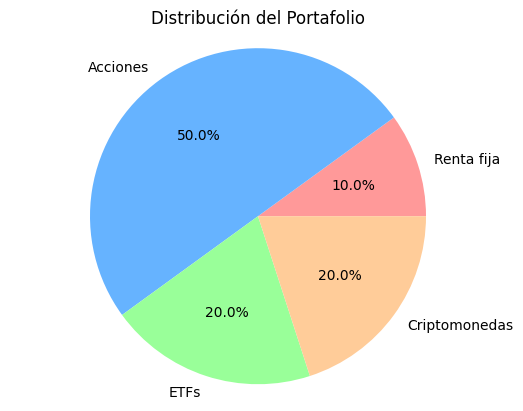


📌 Acciones recomendadas con RSI y MACD:
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


- AAPL: ❌ No se pudo obtener info (Can only use .str accessor with Index, not MultiIndex)


[*********************100%***********************]  1 of 1 completed


- TSLA: ❌ No se pudo obtener info (Can only use .str accessor with Index, not MultiIndex)


[*********************100%***********************]  1 of 1 completed


- NVDA: ❌ No se pudo obtener info (Can only use .str accessor with Index, not MultiIndex)


[*********************100%***********************]  1 of 1 completed


- MSFT: ❌ No se pudo obtener info (Can only use .str accessor with Index, not MultiIndex)


[*********************100%***********************]  1 of 1 completed


- GOOGL: ❌ No se pudo obtener info (Can only use .str accessor with Index, not MultiIndex)

🪙 Criptomonedas sugeridas (ejemplos):
- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)

🏦 Renta fija sugerida:
- Bonos USA: ETF BND o TLT
- Bonos AR en USD: AL30, GD30

🌐 ETFs sugeridos:
- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)

✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!


In [ ]:
# 💸 Asistente de Inversiones Profesional con indicadores reales (Yahoo Finance)
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import time


def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")


def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")


def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def calcular_rsi_macd(ticker):
    try:
        df = yf.download(ticker, period="3mo", interval="1d")
        if df.empty:
            raise ValueError("No se pudieron obtener datos")

        df.ta.rsi(length=14, append=True)
        df.ta.macd(append=True)

        rsi = df["RSI_14"].iloc[-1]
        macd = df["MACD_12_26_9"].iloc[-1]
        signal = df["MACDs_12_26_9"].iloc[-1]

        if pd.isna(rsi) or pd.isna(macd) or pd.isna(signal):
            raise ValueError("RSI o MACD no disponible")

        if rsi < 30 and macd > signal:
            decision = "✅ Entrar ahora (RSI bajo + MACD alcista)"
        elif rsi > 70:
            decision = "⚠️ Sobrecomprado (RSI > 70)"
        else:
            decision = "⏳ Esperar corrección"

        return f"{ticker}: RSI={rsi:.2f}, MACD={macd:.2f}, Signal={signal:.2f} → {decision}"

    except Exception as e:
        return f"{ticker}: ❌ No se pudo obtener info ({e})"


def recomendar_acciones():
    print("\n📌 Acciones recomendadas con RSI y MACD:")
    simbolos = ["AAPL", "TSLA", "NVDA", "MSFT", "GOOGL"]
    for simbolo in simbolos:
        resultado = calcular_rsi_macd(simbolo)
        print(f"- {resultado}")
        time.sleep(1)


def recomendar_criptos():
    print("\n🪙 Criptomonedas sugeridas (ejemplos):")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    if distribucion.get("Acciones", 0) > 0:
        recomendar_acciones()
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


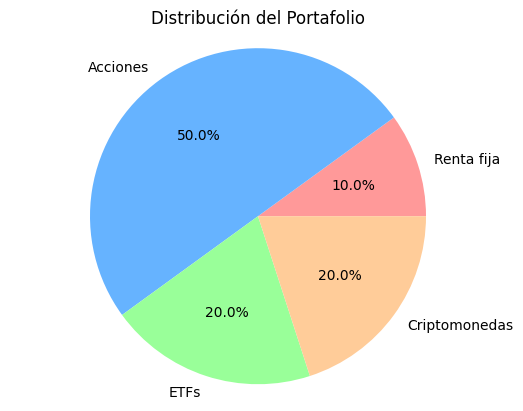


📉 Analizando acciones sobrevendidas (RSI < 30)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

✅ No se detectaron acciones sobrevendidas.

🪙 Criptomonedas sugeridas (ejemplos):
- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)

🏦 Renta fija sugerida:
- Bonos USA: ETF BND o TLT
- Bonos AR en USD: AL30, GD30

🌐 ETFs sugeridos:
- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)

✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!


In [ ]:
# 💸 Asistente de Inversiones Profesional con indicadores reales (Yahoo Finance)
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd
import time


def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")


def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")


def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def calcular_rsi(ticker):
    try:
        df = yf.download(ticker, period="3mo", interval="1d")
        if df.empty:
            return None
        df.ta.rsi(length=14, append=True)
        rsi = df["RSI_14"].iloc[-1]
        return rsi if pd.notna(rsi) else None
    except:
        return None


def recomendar_acciones():
    print("\n📉 Analizando acciones sobrevendidas (RSI < 30)...")
    simbolos = [
        "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN", "AMD", "NFLX", "DIS",
        "INTC", "CRM", "PYPL", "BA", "NKE", "UBER", "BABA", "SQ", "ORCL", "IBM"
    ]

    resultados = []
    for simbolo in simbolos:
        rsi = calcular_rsi(simbolo)
        if rsi is not None:
            resultados.append((simbolo, rsi))
        time.sleep(0.5)  # Para evitar demasiadas peticiones seguidas

    df = pd.DataFrame(resultados, columns=["Ticker", "RSI"])
    sobrevendidas = df[df["RSI"] < 30].sort_values(by="RSI").head(10)

    if sobrevendidas.empty:
        print("✅ No se detectaron acciones sobrevendidas.")
    else:
        print("🔻 Top 10 acciones en zona de sobreventa (RSI < 30):")
        print(sobrevendidas.to_string(index=False))


def recomendar_criptos():
    print("\n🪙 Criptomonedas sugeridas (ejemplos):")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    if distribucion.get("Acciones", 0) > 0:
        recomendar_acciones()
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $40000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $4000.00 (10%)
- Acciones: $20000.00 (50%)
- ETFs: $8000.00 (20%)
- Criptomonedas: $8000.00 (20%)


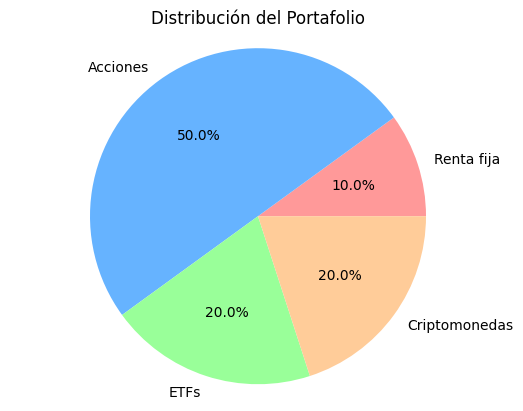


🔎 Analizando RSI de acciones...
❌ Error con AAPL: Can only use .str accessor with Index, not MultiIndex
❌ Error con MSFT: Can only use .str accessor with Index, not MultiIndex
❌ Error con GOOGL: Can only use .str accessor with Index, not MultiIndex
❌ Error con TSLA: Can only use .str accessor with Index, not MultiIndex
❌ Error con NVDA: Can only use .str accessor with Index, not MultiIndex
❌ Error con META: Can only use .str accessor with Index, not MultiIndex
❌ Error con AMZN: Can only use .str accessor with Index, not MultiIndex
❌ Error con AMD: Can only use .str accessor with Index, not MultiIndex
❌ Error con NFLX: Can only use .str accessor with Index, not MultiIndex
❌ Error con DIS: Can only use .str accessor with Index, not MultiIndex
❌ Error con INTC: Can only use .str accessor with Index, not MultiIndex
❌ Error con CRM: Can only use .str accessor with Index, not MultiIndex
❌ Error con PYPL: Can only use .str accessor with Index, not MultiIndex
❌ Error con BA: Can only use .str

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd
import time


def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")


def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")


def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi(simbolos):
    sobrevendidas = []
    sobrecompradas = []

    print("\n🔎 Analizando RSI de acciones...")

    for ticker in simbolos:
        try:
            df = yf.download(ticker, period="3mo", interval="1d", progress=False)
            if df.empty:
                print(f"❌ {ticker}: sin datos.")
                continue

            df.ta.rsi(length=14, append=True)
            rsi_val = df["RSI_14"].iloc[-1]

            if pd.isna(rsi_val):
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            if rsi_val < 30:
                sobrevendidas.append((ticker, rsi_val))
            elif rsi_val > 70:
                sobrecompradas.append((ticker, rsi_val))

        except Exception as e:
            print(f"❌ Error con {ticker}: {e}")

    # Mostrar resultados
    if sobrevendidas:
        sobrevendidas.sort(key=lambda x: x[1])
        print("\n📉 Acciones en zona de sobreventa (RSI < 30):")
        for ticker, rsi in sobrevendidas:
            print(f"- {ticker}: RSI={rsi:.2f}")
    else:
        print("✅ No se detectaron acciones sobrevendidas.")

    if sobrecompradas:
        sobrecompradas.sort(key=lambda x: x[1], reverse=True)
        print("\n📈 Acciones en zona de sobrecompra (RSI > 70):")
        for ticker, rsi in sobrecompradas:
            print(f"- {ticker}: RSI={rsi:.2f}")
    else:
        print("✅ No se detectaron acciones sobrecompradas.")

    # Graficar RSI de las 3 más sobrevendidas
    if sobrevendidas:
        print("\n📊 Graficando RSI de las 3 más sobrevendidas...")
        for ticker, _ in sobrevendidas[:3]:
            try:
                df = yf.download(ticker, period="3mo", interval="1d", progress=False)
                df.ta.rsi(length=14, append=True)
                plt.plot(df.index, df["RSI_14"], label=ticker)
            except:
                continue

        plt.axhline(30, color='red', linestyle='--', label='RSI = 30')
        plt.axhline(70, color='green', linestyle='--', label='RSI = 70')
        plt.title("RSI - Acciones sobrevendidas")
        plt.xlabel("Fecha")
        plt.ylabel("RSI")
        plt.legend()
        plt.tight_layout()
        plt.show()


def recomendar_criptos():
    print("\n🪙 Criptomonedas sugeridas:")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    if distribucion.get("Acciones", 0) > 0:
        simbolos = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN", "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE", "UBER", "BABA", "ORCL", "IBM"]
        analizar_acciones_rsi(simbolos)
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


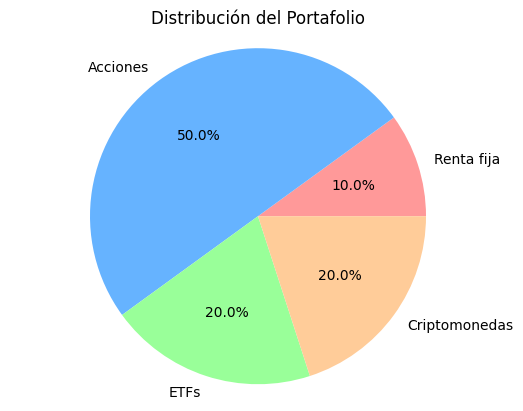


🔍 Analizando RSI y MACD de acciones...

❌ Error con AAPL: Can only use .str accessor with Index, not MultiIndex
❌ Error con MSFT: Can only use .str accessor with Index, not MultiIndex
❌ Error con GOOGL: Can only use .str accessor with Index, not MultiIndex
❌ Error con TSLA: Can only use .str accessor with Index, not MultiIndex
❌ Error con NVDA: Can only use .str accessor with Index, not MultiIndex
❌ Error con META: Can only use .str accessor with Index, not MultiIndex
❌ Error con AMZN: Can only use .str accessor with Index, not MultiIndex
❌ Error con AMD: Can only use .str accessor with Index, not MultiIndex
❌ Error con NFLX: Can only use .str accessor with Index, not MultiIndex
❌ Error con DIS: Can only use .str accessor with Index, not MultiIndex
❌ Error con INTC: Can only use .str accessor with Index, not MultiIndex
❌ Error con CRM: Can only use .str accessor with Index, not MultiIndex
❌ Error con PYPL: Can only use .str accessor with Index, not MultiIndex
❌ Error con BA: Can only 

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")


def obtener_horizonte():
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")


def recomendar_portafolio(perfil):
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if total != 100:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos):
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period="3mo", interval="1d", progress=False)
            if data.empty:
                print(f"❌ {ticker}: sin datos.")
                continue

            # RSI
            data.ta.rsi(length=14, append=True)
            rsi = data["RSI_14"].iloc[-1]
            rsi_estado = "neutral"
            if rsi < 30:
                rsi_estado = "🟢 sobrevendida, posible compra"
            elif rsi > 70:
                rsi_estado = "🔴 sobrecomprada, posible venta"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # MACD
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            if data[["MACD_12_26_9", "MACDs_12_26_9"]].isna().values.any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                continue

            macd_curr = data["MACD_12_26_9"].iloc[-1]
            signal_curr = data["MACDs_12_26_9"].iloc[-1]
            macd_prev = data["MACD_12_26_9"].iloc[-2]
            signal_prev = data["MACDs_12_26_9"].iloc[-2]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: MACD → Cruce alcista (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: MACD → Cruce bajista (venta)")

            print("-" * 70)

        except Exception as e:
            print(f"❌ Error con {ticker}: {e}")


def recomendar_criptos():
    print("\n🪙 Criptomonedas sugeridas:")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    if distribucion.get("Acciones", 0) > 0:
        simbolos = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN", "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE", "UBER", "BABA", "ORCL", "IBM"]
        analizar_acciones_rsi_macd(simbolos)
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


main()


💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


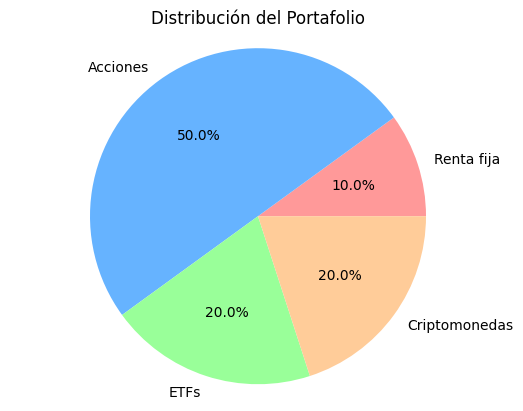


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 46.99 → neutral
❌ Error con AAPL: 'Close'
MSFT: RSI = 71.15 → 🔴 sobrecomprada, posible venta
❌ Error con MSFT: 'Close'
GOOGL: RSI = 56.27 → neutral
❌ Error con GOOGL: 'Close'
TSLA: RSI = 59.75 → neutral
❌ Error con TSLA: 'Close'
NVDA: RSI = 65.77 → 🔴 sobrecomprada, posible venta
❌ Error con NVDA: 'Close'
META: RSI = 70.05 → 🔴 sobrecomprada, posible venta
❌ Error con META: 'Close'
AMZN: RSI = 59.91 → neutral
❌ Error con AMZN: 'Close'
AMD: RSI = 61.02 → neutral
❌ Error con AMD: 'Close'
NFLX: RSI = 68.89 → 🔴 sobrecomprada, posible venta
❌ Error con NFLX: 'Close'
DIS: RSI = 69.01 → 🔴 sobrecomprada, posible venta
❌ Error con DIS: 'Close'
INTC: RSI = 41.64 → neutral
❌ Error con INTC: 'Close'
CRM: RSI = 37.50 → neutral
❌ Error con CRM: 'Close'
PYPL: RSI = 55.82 → neutral
❌ Error con PYPL: 'Close'
BA: RSI = 73.55 → 🔴 sobrecomprada, posible venta
❌ Error con BA: 'Close'
NKE: RSI = 52.44 → neutral
❌ Error con NKE: 'Close'
UBER: RSI = 46.97 → n

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario que ingrese su perfil de inversor.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")


def obtener_horizonte():
    """
    Solicita al usuario que ingrese su horizonte de inversión.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida en base al perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada para su portafolio.
    Los porcentajes deben sumar 100 (se valida con redondeo para evitar imprecisiones de punto flotante).
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose en monto de capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción en base a RSI y MACD adaptando los umbrales del RSI
    según el horizonte de inversión del usuario.

    Los umbrales se definen de la siguiente manera:
    - Corto plazo (1): RSI < 25 indica sobreventa, RSI > 65 indica sobrecompra.
    - Mediano plazo (2): RSI < 30 indica sobreventa, RSI > 70 indica sobrecompra.
    - Largo plazo (3): RSI < 35 indica sobreventa, RSI > 75 indica sobrecompra.
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    # Definir umbrales del RSI según horizonte
    if horizonte == 1:
        lower_threshold = 25
        upper_threshold = 65
    elif horizonte == 2:
        lower_threshold = 30
        upper_threshold = 70
    elif horizonte == 3:
        lower_threshold = 35
        upper_threshold = 75
    else:
        lower_threshold = 30
        upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period="3mo", interval="1d", progress=False)

            # Si las columnas son MultiIndex, se aplanan para asegurar un acceso correcto
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"❌ {ticker}: sin datos.")
                continue

            # Calcular RSI y agregarlo al DataFrame
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue
            rsi = data["RSI_14"].iloc[-1]

            # Evaluar el estado del RSI según el horizonte de inversión
            if rsi < lower_threshold:
                rsi_estado = "🟢 sobrevendida, posible compra"
            elif rsi > upper_threshold:
                rsi_estado = "🔴 sobrecomprada, posible venta"
            else:
                rsi_estado = "neutral"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # Calcular MACD basado en la columna 'Close'
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9"]
            if data[required_cols].isna().values.any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                continue

            macd_curr = data["MACD_12_26_9"].iloc[-1]
            signal_curr = data["MACDs_12_26_9"].iloc[-1]
            macd_prev = data["MACD_12_26_9"].iloc[-2]
            signal_prev = data["MACDs_12_26_9"].iloc[-2]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: MACD → Cruce alcista (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: MACD → Cruce bajista (venta)")

            print("-" * 70)

        except Exception as e:
            print(f"❌ Error con {ticker}: {e}")


def recomendar_criptos():
    """
    Muestra las criptomonedas sugeridas.
    """
    print("\n🪙 Criptomonedas sugeridas:")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    # Solicitar capital al usuario
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    # Obtener perfil y horizonte
    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    # Elegir distribución sugerida según perfil o distribución personalizada
    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Recomendaciones según la distribución seleccionada
    if distribucion.get("Acciones", 0) > 0:
        # Lista de acciones a analizar
        simbolos = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(simbolos, horizonte)
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


if __name__ == "__main__":
    main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $100000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $10000.00 (10%)
- Acciones: $50000.00 (50%)
- ETFs: $20000.00 (20%)
- Criptomonedas: $20000.00 (20%)


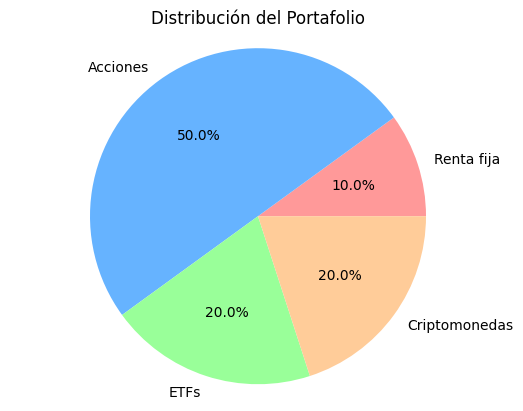


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 46.99 → Neutral

MSFT: RSI = 71.15 → Sobrecomprada, posible venta

GOOGL: RSI = 56.27 → Neutral

TSLA: RSI = 59.75 → Neutral

NVDA: RSI = 65.77 → Neutral

META: RSI = 70.05 → Sobrecomprada, posible venta

AMZN: RSI = 59.91 → Neutral

AMD: RSI = 61.02 → Neutral

NFLX: RSI = 68.89 → Neutral

DIS: RSI = 69.01 → Neutral

INTC: RSI = 41.64 → Neutral

CRM: RSI = 37.50 → Neutral

PYPL: RSI = 55.82 → Neutral

BA: RSI = 73.55 → Sobrecomprada, posible venta

NKE: RSI = 52.44 → Neutral

UBER: RSI = 46.97 → Neutral

BABA: RSI = 39.01 → Neutral

ORCL: RSI = 68.49 → Neutral

IBM: RSI = 60.75 → Neutral


🪙 Criptomonedas sugeridas:
- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)

🏦 Renta fija sugerida:
- Bonos USA: ETF BND o TLT
- Bonos AR en USD: AL30, GD30

🌐 ETFs sugeridos:
- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)

✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!


In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución recomendada según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada para su portafolio.
    Los porcentajes deben sumar 100 (se valida con redondeo para evitar imprecisiones).
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Por favor, ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción en base a RSI y MACD.

    Se determina el estado del RSI considerando:
      - RSI menor o igual a 30: sobrevendida, posible compra [Se muestra en verde].
      - RSI mayor o igual a 70: sobrecomprada, posible venta [Se muestra en rojo].
      - En otro caso: neutral [Se muestra en amarillo].

    Además se utiliza el MACD para confirmar señales.
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    # Definimos umbrales fijos para RSI
    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period="3mo", interval="1d", progress=False)

            # Aplanar columnas en caso de MultiIndex
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            # Calcular RSI y agregarlo al DataFrame
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            # Definir el estado del RSI con colores usando códigos ANSI
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"

            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # Calcular MACD en base a la columna 'Close'
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9"]
            if data[required_cols].isna().values.any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                continue

            macd_curr = data["MACD_12_26_9"].iloc[-1]
            signal_curr = data["MACDs_12_26_9"].iloc[-1]
            macd_prev = data["MACD_12_26_9"].iloc[-2]
            signal_prev = data["MACDs_12_26_9"].iloc[-2]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: MACD → Cruce alcista (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: MACD → Cruce bajista (venta)")

            print("-" * 70)

        except Exception:
            # Mensaje amigable sin mostrar detalles técnicos
            print(f"")


def recomendar_criptos():
    """
    Muestra las criptomonedas sugeridas.
    """
    print("\n🪙 Criptomonedas sugeridas:")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    # Solicitar capital al usuario
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    # Elegir distribución sugerida o personalizada
    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Análisis y recomendaciones según la distribución seleccionada
    if distribucion.get("Acciones", 0) > 0:
        simbolos = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(simbolos, horizonte)
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


if __name__ == "__main__":
    main()




💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


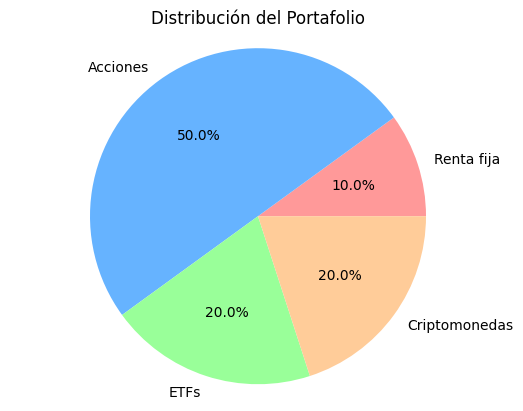


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 46.99 → Neutral
MSFT: RSI = 71.15 → Sobrecomprada, posible venta
GOOGL: RSI = 56.27 → Neutral
TSLA: RSI = 59.75 → Neutral
NVDA: RSI = 65.77 → Neutral
META: RSI = 70.05 → Sobrecomprada, posible venta
AMZN: RSI = 59.91 → Neutral
AMD: RSI = 61.02 → Neutral
NFLX: RSI = 68.89 → Neutral
DIS: RSI = 69.01 → Neutral
INTC: RSI = 41.64 → Neutral
CRM: RSI = 37.50 → Neutral
PYPL: RSI = 55.82 → Neutral
BA: RSI = 73.55 → Sobrecomprada, posible venta
NKE: RSI = 52.44 → Neutral
UBER: RSI = 46.97 → Neutral
BABA: RSI = 39.01 → Neutral
ORCL: RSI = 68.49 → Neutral
IBM: RSI = 60.75 → Neutral

🪙 Criptomonedas sugeridas:
- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)

🏦 Renta fija sugerida:
- Bonos USA: ETF BND o TLT
- Bonos AR en USD: AL30, GD30

🌐 ETFs sugeridos:
- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)

✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!


In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución recomendada según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada para su portafolio.
    Los porcentajes deben sumar 100 (se valida con redondeo para evitar imprecisiones).
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Por favor, ingresá un valor entre 0 y 100")
            except ValueError:
                print("Ingresá un número válido")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción en base a RSI y MACD.

    Se determina el estado del RSI considerando:
      - RSI menor o igual a 30: sobrevendida, posible compra [Se muestra en verde].
      - RSI mayor o igual a 70: sobrecomprada, posible venta [Se muestra en rojo].
      - En otro caso: neutral [Se muestra en amarillo].

    Además se utiliza el MACD para confirmar señales.
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    # Definimos umbrales fijos para RSI
    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period="3mo", interval="1d", progress=False)

            # Aplanar columnas en caso de MultiIndex
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            # Calcular RSI y agregarlo al DataFrame
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            # Definir el estado del RSI con colores usando códigos ANSI
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"

            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # Calcular MACD en base a la columna 'Close'
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9"]
            if data[required_cols].isna().values.any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                continue

            macd_curr = data["MACD_12_26_9"].iloc[-1]
            signal_curr = data["MACDs_12_26_9"].iloc[-1]
            macd_prev = data["MACD_12_26_9"].iloc[-2]
            signal_prev = data["MACDs_12_26_9"].iloc[-2]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: MACD → Cruce alcista (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: MACD → Cruce bajista (venta)")

            print("-" * 70)

        except Exception:
            # Suprimir los errores para no mostrarlos
            pass


def recomendar_criptos():
    """
    Muestra las criptomonedas sugeridas.
    """
    print("\n🪙 Criptomonedas sugeridas:")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    # Solicitar capital al usuario
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    # Elegir distribución sugerida o personalizada
    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Análisis y recomendaciones según la distribución seleccionada
    if distribucion.get("Acciones", 0) > 0:
        simbolos = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(simbolos, horizonte)
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


if __name__ == "__main__":
    main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $20000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 1

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 3

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $12000.00 (60%)
- Acciones: $4000.00 (20%)
- ETFs: $2000.00 (10%)
- Criptomonedas: $2000.00 (10%)


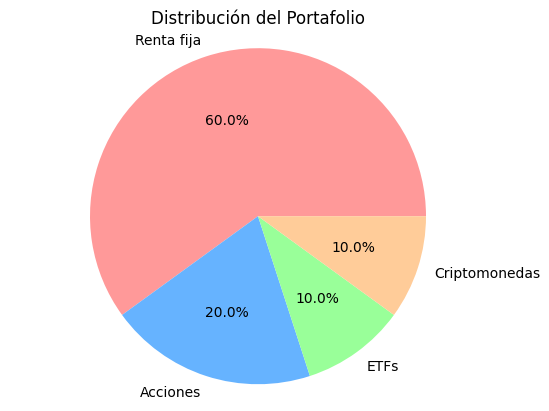


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 46.99 → Neutral
AAPL: MACD Histograma = -0.35 → Momentum bajista
----------------------------------------------------------------------
MSFT: RSI = 71.15 → Sobrecomprada, posible venta
MSFT: MACD Histograma = -1.20 → Momentum bajista
----------------------------------------------------------------------
GOOGL: RSI = 56.27 → Neutral
GOOGL: MACD Histograma = 0.59 → Momentum alcista
----------------------------------------------------------------------
TSLA: RSI = 59.75 → Neutral
TSLA: MACD Histograma = -0.96 → Momentum bajista
📉 TSLA: Cruce bajista detectado (posible venta)
----------------------------------------------------------------------
NVDA: RSI = 65.77 → Neutral
NVDA: MACD Histograma = 0.14 → Momentum alcista
----------------------------------------------------------------------
META: RSI = 70.05 → Sobrecomprada, posible venta
META: MACD Histograma = 1.02 → Momentum alcista
📈 META: Cruce alcista detectado (posible compra)
----

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución recomendada según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada para su portafolio.
    Los porcentajes deben sumar 100 (se valida con redondeo para evitar imprecisiones).
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Por favor, ingresá un valor entre 0 y 100.")
            except ValueError:
                print("Ingresá un número válido.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción en base a RSI y MACD.

    Se calcula el RSI (14 días) y se muestra de la siguiente manera:
      - RSI ≤ 30: Sobrevendida (verde, posible compra)
      - RSI ≥ 70: Sobrecomprada (rojo, posible venta)
      - Entre esos valores: Neutral (amarillo)

    Se calcula el MACD y se muestra el valor del histograma (MACDh_12_26_9) con:
      - Verde: Momentum alcista (valor positivo)
      - Rojo: Momentum bajista (valor negativo)
      - Amarillo: Sin dirección clara (cercano a 0)

    Además, se detectan cruces entre la línea MACD y la señal.
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    # Umbrales fijos para RSI
    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period="3mo", interval="1d", progress=False)

            # Aplanar columnas en caso de MultiIndex
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            # Calcular RSI
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # Buscar flexible la columna 'Close'
            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            # Calcular MACD utilizando la columna 'Close'
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            # Verificar los valores de la última fila
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            # Evaluar el histograma MACD
            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"   # Verde
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"   # Rojo
            else:
                histo_status = "\033[93mSin dirección clara\033[0m" # Amarillo
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            # Intentar obtener el penúltimo valor
            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (posible compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (posible venta)")

            print("-" * 70)

        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def recomendar_criptos():
    """
    Muestra las criptomonedas sugeridas.
    """
    print("\n🪙 Criptomonedas sugeridas:")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    # Solicitar capital al usuario.
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    # Seleccionar distribución sugerida o personalizada.
    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida.")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Ejecución del análisis según la distribución seleccionada.
    if distribucion.get("Acciones", 0) > 0:
        simbolos = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(simbolos, horizonte)
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


if __name__ == "__main__":
    main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $10000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 1

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 3

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $6000.00 (60%)
- Acciones: $2000.00 (20%)
- ETFs: $1000.00 (10%)
- Criptomonedas: $1000.00 (10%)


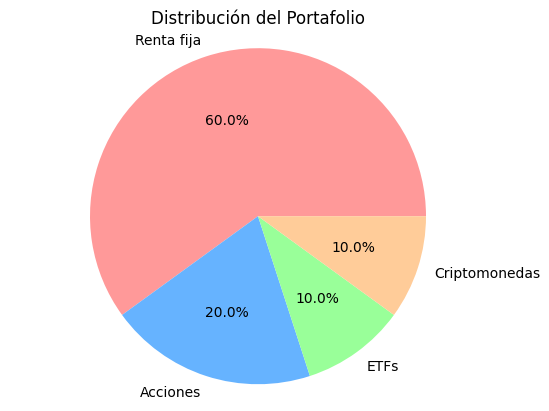


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 50.11 → Neutral
AAPL: MACD Histograma = -4.27 → Momentum bajista
----------------------------------------------------------------------
MSFT: RSI = 65.89 → Neutral
MSFT: MACD Histograma = -1.11 → Momentum bajista
----------------------------------------------------------------------
GOOGL: RSI = 55.54 → Neutral
GOOGL: MACD Histograma = -2.15 → Momentum bajista
----------------------------------------------------------------------
TSLA: RSI = 57.78 → Neutral
TSLA: MACD Histograma = 7.58 → Momentum alcista
----------------------------------------------------------------------
NVDA: RSI = 69.97 → Neutral
NVDA: MACD Histograma = -1.06 → Momentum bajista
----------------------------------------------------------------------
META: RSI = 68.09 → Neutral
META: MACD Histograma = 4.94 → Momentum alcista
----------------------------------------------------------------------
AMZN: RSI = 59.24 → Neutral
AMZN: MACD Histograma = -0.08 → Momentum ba

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución recomendada según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada para su portafolio.
    Los porcentajes deben sumar 100 (se valida con redondeo para evitar imprecisiones).
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Por favor, ingresá un valor entre 0 y 100.")
            except ValueError:
                print("Ingresá un número válido.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción en base a RSI y MACD.

    Se calcula el RSI (14 días) y se muestra de la siguiente manera:
      - RSI ≤ 30: Sobrevendida (verde, posible compra)
      - RSI ≥ 70: Sobrecomprada (rojo, posible venta)
      - Entre esos valores: Neutral (amarillo)

    Se calcula el MACD y se muestra el valor del histograma (MACDh_12_26_9) con:
      - Verde: Momentum alcista (valor positivo)
      - Rojo: Momentum bajista (valor negativo)
      - Amarillo: Sin dirección clara (cercano a 0)

    Además, se detectan cruces entre la línea MACD y la señal.

    La temporalidad se adapta según el horizonte:
      - Corto plazo: datos diarios (interval="1d", period="3mo")
      - Mediano plazo: datos semanales (interval="1wk", period="1y")
      - Largo plazo: datos mensuales (interval="1mo", period="5y")
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    # Definir la temporalidad según el horizonte:
    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    # Umbrales fijos para RSI
    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)

            # Aplanar columnas en caso de MultiIndex
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            # Calcular RSI y agregarlo al DataFrame.
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # Busqueda flexible de la columna 'Close'
            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            # Calcular MACD usando la columna 'Close'
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]

            # Revisar el último registro para la disponibilidad del MACD
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            # Evaluar el histograma MACD
            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"   # Verde
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"   # Rojo
            else:
                histo_status = "\033[93mSin dirección clara\033[0m" # Amarillo
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            # Evaluar cruces: usar el penúltimo registro para comparar con el último.
            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)

        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def recomendar_criptos():
    """
    Muestra las criptomonedas sugeridas.
    """
    print("\n🪙 Criptomonedas sugeridas:")
    print("- Bitcoin (BTC), Ethereum (ETH), Solana (SOL)")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    # Solicitar capital al usuario.
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    # Elegir distribución sugerida o personalizada.
    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida.")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Realizar análisis según la distribución seleccionada.
    if distribucion.get("Acciones", 0) > 0:
        simbolos = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(simbolos, horizonte)
    if distribucion.get("Criptomonedas", 0) > 0:
        recomendar_criptos()
    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()
    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


if __name__ == "__main__":
    main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $8000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
Elegí una opción (1/2/3): 2

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
Elegí una opción (1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
Elegí una opción (1/2): 1

📊 Distribución seleccionada:
- Renta fija: $2400.00 (30%)
- Acciones: $3200.00 (40%)
- ETFs: $1600.00 (20%)
- Criptomonedas: $800.00 (10%)


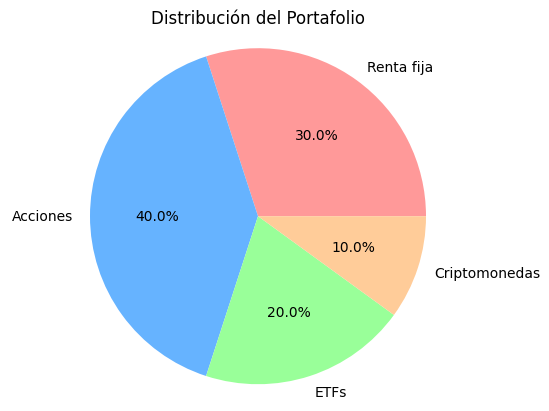


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 48.90 → Neutral
AAPL: MACD Histograma = -0.13 → Momentum bajista
----------------------------------------------------------------------
MSFT: RSI = 71.53 → Sobrecomprada, posible venta
MSFT: MACD Histograma = -1.29 → Momentum bajista
----------------------------------------------------------------------
GOOGL: RSI = 54.10 → Neutral
GOOGL: MACD Histograma = 0.23 → Momentum alcista
----------------------------------------------------------------------
TSLA: RSI = 63.68 → Neutral
TSLA: MACD Histograma = -1.12 → Momentum bajista
----------------------------------------------------------------------
NVDA: RSI = 69.60 → Neutral
NVDA: MACD Histograma = 0.28 → Momentum alcista
----------------------------------------------------------------------
META: RSI = 69.55 → Neutral
META: MACD Histograma = 1.47 → Momentum alcista
----------------------------------------------------------------------
AMZN: RSI = 60.69 → Neutral
AMZN: MACD Histograma =

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    while True:
        horizonte = input("Elegí una opción (1/2/3): ")
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución recomendada según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada para su portafolio.
    Los porcentajes deben sumar 100 (se valida con redondeo).
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            try:
                porcentaje = float(input(f"% a invertir en {tipo}: "))
                if 0 <= porcentaje <= 100:
                    distribucion[tipo] = porcentaje
                    total += porcentaje
                    break
                else:
                    print("Por favor, ingresá un valor entre 0 y 100.")
            except ValueError:
                print("Ingresá un número válido.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción basándose en RSI y MACD.
    Se calcula el RSI (14 días) y se clasifica:
      • ≤ 30: Sobrevendida (verde, posible compra)
      • ≥ 70: Sobrecomprada (rojo, posible venta)
      • Entre esos valores: Neutral (amarillo)
    Luego se calcula el MACD y se muestra su histograma (MACDh_12_26_9):
      • Positivo: Momentum alcista (verde)
      • Negativo: Momentum bajista (rojo)
      • Cero: Sin dirección clara (amarillo)
    Se detectan cruces usando el penúltimo dato para comparar con el último.
    La temporalidad se adapta según el horizonte:
      • Corto plazo: interval="1d", period="3mo"
      • Mediano plazo: interval="1wk", period="1y"
      • Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)

            if isinstance(data.columns, pd.MultiIndex):
                # Aplanar el MultiIndex: buscar "Close" en el nivel 1 o aplanar genéricamente.
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # Asegurarse de contar con la columna "Close"
            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)

        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda basándose en RSI y MACD, adaptando la temporalidad
    según el horizonte de inversión. Se emplean las mismas condiciones que para acciones.

    Temporalidad:
      - Corto plazo: interval="1d", period="3mo"
      - Mediano plazo: interval="1wk", period="1y"
      - Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            # Aplanar MultiIndex si es necesario
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)

        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    # Solicitar capital al usuario.
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    perfil = obtener_perfil()
    horizonte = obtener_horizonte()

    print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
    print("1 - Usar distribución sugerida")
    print("2 - Crear mi propia distribución")
    while True:
        opcion = input("Elegí una opción (1/2): ")
        if opcion == '1':
            distribucion = recomendar_portafolio(perfil)
            break
        elif opcion == '2':
            distribucion = elegir_distribucion_personalizada()
            break
        else:
            print("Opción inválida.")

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Análisis para acciones
    if distribucion.get("Acciones", 0) > 0:
        accionistas = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(accionistas, horizonte)

    # Análisis para criptomonedas
    if distribucion.get("Criptomonedas", 0) > 0:
        print("\n🪙 Criptomonedas sugeridas:")
        crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
        analizar_cripto(crypto_tickers, horizonte)

    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()

    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


if __name__ == "__main__":
    main()


In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    (No se incluye opción de volver en este primer paso.)
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    Se incluye la opción 0 - Volver, para poder retroceder y cambiar la decisión (por ejemplo, recuperar el perfil anterior).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        horizonte = input("Elegí una opción (0/1/2/3): ")
        if horizonte == "0":
            return None
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución recomendada según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada para su portafolio.
    Los porcentajes deben sumar 100.
    En cada entrada, se ofrece la opción de "0" para volver (cancelar la edición).
    Si el usuario ingresa 0 en alguna posición, la función retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción basándose en RSI y MACD.
    - Calcula el RSI (14 días) y lo clasifica:
         • ≤ 30: Sobrevendida (verde, posible compra)
         • ≥ 70: Sobrecomprada (rojo, posible venta)
         • Entre esos valores: Neutral (amarillo)
    - Calcula el MACD y muestra el histograma (MACDh_12_26_9):
         • Valor positivo: Momentum alcista (verde)
         • Valor negativo: Momentum bajista (rojo)
         • Cero: Sin dirección clara (amarillo)
    - Se detectan cruces usando el penúltimo registro para comparar con el último.
    La temporalidad se adapta según el horizonte:
         • Corto plazo: interval="1d", period="3mo"
         • Mediano plazo: interval="1wk", period="1y"
         • Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                # Aplanar el MultiIndex: si "Close" se encuentra en el nivel 1, úsalo; sino aplanamos genéricamente.
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            # Verificar que exista la columna "Close"
            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda basándose en RSI y MACD, con las mismas condiciones que para acciones.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: interval="1d", period="3mo"
      - Mediano plazo: interval="1wk", period="1y"
      - Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            # Aplanar MultiIndex si es necesario
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")

    # Solicitar capital (no se agrega opción de volver en este paso)
    while True:
        try:
            capital = float(input("\n¿Cuánto capital tenés para invertir? $"))
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    # Bucle para seleccionar perfil, horizonte y distribución, permitiendo volver atrás
    while True:
        perfil = obtener_perfil()
        horizonte = obtener_horizonte()
        if horizonte is None:
            print("⤺ Volviendo a seleccionar el perfil.")
            continue  # Vuelve a pedir perfil y horizonte

        print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
        print("1 - Usar distribución sugerida")
        print("2 - Crear mi propia distribución")
        print("0 - Volver")
        opcion = input("Elegí una opción (0/1/2): ")
        if opcion == "0":
            print("⤺ Volviendo a seleccionar horizonte.")
            continue  # Vuelve a pedir horizonte (y perfil)
        elif opcion == "1":
            distribucion = recomendar_portafolio(perfil)
            break  # Salimos del bucle de selección
        elif opcion == "2":
            distribucion = elegir_distribucion_personalizada()
            if distribucion is None:
                print("⤺ Volviendo a la selección de distribución.")
                continue
            else:
                break
        else:
            print("Opción inválida. Volviendo a seleccionar horizonte.")
            continue

    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Análisis para acciones
    if distribucion.get("Acciones", 0) > 0:
        accionistas = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(accionistas, horizonte)

    # Análisis para criptomonedas
    if distribucion.get("Criptomonedas", 0) > 0:
        print("\n🪙 Criptomonedas sugeridas:")
        crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
        analizar_cripto(crypto_tickers, horizonte)

    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()

    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")


if __name__ == "__main__":
    main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸


KeyboardInterrupt: Interrupted by user

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    (No se incluye opción de volver en este primer paso.)
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    while True:
        perfil = input("Elegí una opción (1/2/3): ")
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    Se incluye la opción 0 - Volver, para poder retroceder y cambiar la decisión.
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        horizonte = input("Elegí una opción (0/1/2/3): ")
        if horizonte == "0":
            return None
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (cancelar y reingresar).
    Si el usuario ingresa 0 en alguna posición, la función retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción basándose en RSI y MACD.
    Se calcula el RSI (14 días) y se clasifica:
      • ≤ 30: Sobrevendida (verde, posible compra)
      • ≥ 70: Sobrecomprada (rojo, posible venta)
      • Entre esos valores: Neutral (amarillo)
    Luego se calcula el MACD y se muestra su histograma (MACDh_12_26_9):
      • Valor positivo: Momentum alcista (verde)
      • Valor negativo: Momentum bajista (rojo)
      • 0: Sin dirección clara (amarillo)
    Se detectan cruces usando el penúltimo registro comparado con el último.
    La temporalidad se adapta según el horizonte:
      • Corto plazo: interval="1d", period="3mo"
      • Mediano plazo: interval="1wk", period="1y"
      • Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda basándose en RSI y MACD, con las mismas condiciones que para acciones.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: interval="1d", period="3mo"
      - Mediano plazo: interval="1wk", period="1y"
      - Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    while True:
        print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")
        # Solicitar capital: se permite que si el usuario ingresa "volver" o "0", se reinicie la entrada.
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $ (o escribe 'volver' para reiniciar): ")
            if capital_input.strip().lower() in ["volver", "0"]:
                print("⤺ Reiniciando el ingreso del capital.")
                continue  # Vuelve a pedir el capital
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Bucle para seleccionar perfil, horizonte y distribución permitiendo volver atrás.
        while True:
            perfil = obtener_perfil()
            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Volviendo a seleccionar el perfil.")
                continue  # Volver a pedir perfil y horizonte

            print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
            print("1 - Usar distribución sugerida")
            print("2 - Crear mi propia distribución")
            print("0 - Volver")
            opcion = input("Elegí una opción (0/1/2): ")
            if opcion == "0":
                print("⤺ Volviendo a seleccionar horizonte.")
                continue  # Volver a pedir horizonte (y perfil)
            elif opcion == "1":
                distribucion = recomendar_portafolio(perfil)
                break  # Salir del bucle de selección
            elif opcion == "2":
                distribucion = elegir_distribucion_personalizada()
                if distribucion is None:
                    print("⤺ Volviendo a la selección de distribución.")
                    continue
                else:
                    break
            else:
                print("Opción inválida. Volviendo a seleccionar horizonte.")
                continue

        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        # Análisis para acciones
        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        # Análisis para criptomonedas
        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija()

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs()

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        respuesta = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (S/N): ").strip().lower()
        if respuesta != 's':
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break


if __name__ == "__main__":
    main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸


KeyboardInterrupt: Interrupted by user

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    Se incluye la opción 0 para volver.
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    while True:
        perfil = input("Elegí una opción (0/1/2/3): ")
        if perfil == "0":
            return None
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    Se incluye la opción 0 para volver, permitiendo retroceder y cambiar la decisión.
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        horizonte = input("Elegí una opción (0/1/2/3): ")
        if horizonte == "0":
            return None
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (cancelar y reingresar).
    Si el usuario ingresa 0 en alguna posición, la función retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción basándose en RSI y MACD.
    Se calcula el RSI (14 días) y se clasifica:
      • ≤ 30: Sobrevendida (verde, posible compra)
      • ≥ 70: Sobrecomprada (rojo, posible venta)
      • Entre esos valores: Neutral (amarillo)
    Luego se calcula el MACD y se muestra su histograma (MACDh_12_26_9):
      • Valor positivo: Momentum alcista (verde)
      • Valor negativo: Momentum bajista (rojo)
      • 0: Sin dirección clara (amarillo)
    Se detectan cruces usando el penúltimo registro comparado con el último.
    La temporalidad se adapta según el horizonte:
      • Corto plazo: interval="1d", period="3mo"
      • Mediano plazo: interval="1wk", period="1y"
      • Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda basándose en RSI y MACD, con las mismas condiciones que para acciones.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: interval="1d", period="3mo"
      - Mediano plazo: interval="1wk", period="1y"
      - Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")

    if horizonte == 1:
        period = "3mo"
        interval = "1d"
    elif horizonte == 2:
        period = "1y"
        interval = "1wk"
    elif horizonte == 3:
        period = "5y"
        interval = "1mo"
    else:
        period = "3mo"
        interval = "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    while True:
        print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")
        # Solicitar capital SIN opción de volver: se debe ingresar un monto numérico válido.
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Seleccionar perfil, horizonte y distribución permitiendo volver atrás.
        while True:
            perfil = obtener_perfil()
            if perfil is None:
                print("⤺ Reiniciando el proceso completo.")
                continue  # Reinicia desde el inicio

            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Volviendo a seleccionar el perfil.")
                continue  # Reinicia la selección de perfil y horizonte

            print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
            print("1 - Usar distribución sugerida")
            print("2 - Crear mi propia distribución")
            print("0 - Volver")
            opcion = input("Elegí una opción (0/1/2): ")
            if opcion == "0":
                print("⤺ Volviendo a seleccionar horizonte y perfil.")
                continue  # Reinicia la selección de perfil y horizonte
            elif opcion == "1":
                distribucion = recomendar_portafolio(perfil)
                break  # Salir del bucle de selección
            elif opcion == "2":
                distribucion = elegir_distribucion_personalizada()
                if distribucion is None:
                    print("⤺ Volviendo a la selección de distribución.")
                    continue
                else:
                    break
            else:
                print("Opción inválida. Reiniciando la selección de horizonte y perfil.")
                continue

        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        # Análisis para acciones
        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        # Análisis para criptomonedas
        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija()

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs()

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        respuesta = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (S/N): ").strip().lower()
        if respuesta != 's':
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break


if __name__ == "__main__":
    main()




💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $: 1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 0
⤺ Reiniciando el proceso completo.

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver


KeyboardInterrupt: Interrupted by user

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    Se incluye la opción 0 para volver.
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    while True:
        perfil = input("Elegí una opción (0/1/2/3): ")
        if perfil == "0":
            return None
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")


def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    Se incluye la opción 0 para volver.
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        horizonte = input("Elegí una opción (0/1/2/3): ")
        if horizonte == "0":
            return None
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")


def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}


def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (cancelar y reingresar).
    Si el usuario ingresa 0 en alguna posición, la función retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion


def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()


def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")


def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción basándose en RSI y MACD.
    Se calcula el RSI (14 días) y se clasifica:
      • ≤ 30: Sobrevendida (verde, posible compra)
      • ≥ 70: Sobrecomprada (rojo, posible venta)
      • Entre esos valores: Neutral (amarillo)
    Luego se calcula el MACD y se muestra su histograma (MACDh_12_26_9):
      • Valor positivo: Momentum alcista (verde)
      • Valor negativo: Momentum bajista (rojo)
      • 0: Sin dirección clara (amarillo)
    Se detectan cruces usando el penúltimo registro comparado con el último.
    La temporalidad se adapta según el horizonte:
      • Corto plazo: interval = "1d", period = "3mo"
      • Mediano plazo: interval = "1wk", period = "1y"
      • Largo plazo: interval = "1mo", period = "5y"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")

    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda basándose en RSI y MACD, con las mismas condiciones que para acciones.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: interval = "1d", period = "3mo"
      - Mediano plazo: interval = "1wk", period = "1y"
      - Largo plazo: interval = "1mo", period = "5y"
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")

    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")


def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")


def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")


def main():
    print("\n💸 Bienvenido al Asistente de Inversiones Profesional 💸")
    # Solicitar el capital UNA sola vez por sesión.
    while True:
        capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
        try:
            capital = float(capital_input)
            if capital > 0:
                break
            else:
                print("El capital debe ser mayor a 0.")
        except ValueError:
            print("Ingresá un número válido.")

    # Bucle para la selección de perfil, horizonte y distribución.
    while True:
        # Se mantiene el capital ingresado sin volver a pedirlo.
        perfil = obtener_perfil()
        if perfil is None:
            print("⤺ Debés seleccionar un perfil para continuar.")
            continue  # Se vuelve a pedir el perfil sin reiniciar el capital.
        horizonte = obtener_horizonte()
        if horizonte is None:
            print("⤺ Volviendo a la selección de perfil/horizonte.")
            continue  # Se vuelve a pedir perfil y horizonte.

        # Bucle para la selección de distribución.
        while True:
            print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
            print("1 - Usar distribución sugerida")
            print("2 - Crear mi propia distribución")
            print("0 - Volver")
            opcion = input("Elegí una opción (0/1/2): ")
            if opcion not in ["0", "1", "2"]:
                print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                continue
            if opcion == "0":
                print("⤺ Volviendo a la selección de perfil y horizonte.")
                break  # Rompe el bucle de distribución para reiniciar perfil/horizonte.
            elif opcion == "1":
                distribucion = recomendar_portafolio(perfil)
                break
            elif opcion == "2":
                distribucion = elegir_distribucion_personalizada()
                if distribucion is None:
                    print("⤺ Volviendo a la selección de distribución.")
                    continue
                else:
                    break
        if opcion == "0":
            continue  # Reinicia la selección de perfil y horizonte sin re-preguntar el capital.
        else:
            # Se han obtenido perfil, horizonte y distribución válidos. Salir del bucle.
            break

    # Mostrar resultados y análisis.
    mostrar_desglose(distribucion, capital)
    mostrar_grafico(distribucion)

    # Análisis para acciones.
    if distribucion.get("Acciones", 0) > 0:
        accionistas = [
            "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
            "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
            "UBER", "BABA", "ORCL", "IBM"
        ]
        analizar_acciones_rsi_macd(accionistas, horizonte)

    # Análisis para criptomonedas.
    if distribucion.get("Criptomonedas", 0) > 0:
        print("\n🪙 Criptomonedas sugeridas:")
        crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
        analizar_cripto(crypto_tickers, horizonte)

    if distribucion.get("Renta fija", 0) > 0:
        recomendar_renta_fija()

    if distribucion.get("ETFs", 0) > 0:
        recomendar_etfs()

    print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
    respuesta = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (S/N): ").strip().lower()
    if respuesta == 's':
        # Si decide repetir, se reinicia la selección completa (se volverá a pedir perfil, horizonte y distribución,
        # y se pedirá capital de nuevo en esta nueva sesión).
        main()
    else:
        print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")


if __name__ == "__main__":
    main()



💸 Bienvenido al Asistente de Inversiones Profesional 💸

¿Cuánto capital tenés para invertir? $: 10000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 0
⤺ Debés seleccionar un perfil para continuar.

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver


KeyboardInterrupt: Interrupted by user

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

def obtener_perfil():
    """
    Solicita al usuario el perfil de inversor.
    Se incluye la opción 0 para volver.
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    while True:
        perfil = input("Elegí una opción (0/1/2/3): ")
        if perfil == "0":
            return None
        if perfil in ['1', '2', '3']:
            return int(perfil)
        print("Opción inválida.")

def obtener_horizonte():
    """
    Solicita al usuario el horizonte de inversión.
    Se incluye la opción 0 para volver.
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si el usuario decide volver.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        horizonte = input("Elegí una opción (0/1/2/3): ")
        if horizonte == "0":
            return None
        if horizonte in ['1', '2', '3']:
            return int(horizonte)
        print("Opción inválida.")

def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver.
    Si se ingresa "0" en alguna posición, se retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción basándose en RSI y MACD.
    Se calcula el RSI (14 días) y se clasifica:
      • ≤ 30: Sobrevendida (verde, posible compra)
      • ≥ 70: Sobrecomprada (rojo, posible venta)
      • Entre esos valores: Neutral (amarillo)
    Luego se calcula el MACD y se muestra su histograma (MACDh_12_26_9):
      • Valor positivo: Momentum alcista (verde)
      • Valor negativo: Momentum bajista (rojo)
      • 0: Sin dirección clara (amarillo)
    Se detectan cruces usando el penúltimo registro comparado con el último.
    La temporalidad se adapta según el horizonte:
      • Corto plazo: interval="1d", period="3mo"
      • Mediano plazo: interval="1wk", period="1y"
      • Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= lower_threshold:
                # Si es mayor o igual al umbral superior:
                if rsi >= upper_threshold:
                    rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
                else:
                    rsi_estado = "\033[93mNeutral\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda basándose en RSI y MACD.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: interval="1d", period="3mo"
      - Mediano plazo: interval="1wk", period="1y"
      - Largo plazo: interval="1mo", period="5y"
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            required_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[required_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2_macd = data[required_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2_macd["MACD_12_26_9"]
            signal_prev = last2_macd["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def recomendar_renta_fija():
    """
    Muestra las opciones de renta fija sugeridas.
    """
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")

def recomendar_etfs():
    """
    Muestra los ETFs sugeridos.
    """
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")

def main():
    while True:
        # --- Se pide el capital solo UNA VEZ por sesión ---
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # --- Ahora se piden los parámetros (perfil, horizonte y distribución) ---
        restart_params = False
        while True:
            perfil = obtener_perfil()
            if perfil is None:
                print("⤺ Opción 'Volver' detectada. Reiniciando todo (se volverá a pedir el capital).")
                restart_params = True
                break
            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Opción 'Volver' detectada. Reiniciando todo (se volverá a pedir el capital).")
                restart_params = True
                break
            # Bucle para la selección de distribución.
            while True:
                print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
                print("1 - Usar distribución sugerida")
                print("2 - Crear mi propia distribución")
                print("0 - Volver")
                opcion = input("Elegí una opción (0/1/2): ")
                if opcion not in ["0", "1", "2"]:
                    print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                    continue
                if opcion == "0":
                    print("⤺ Opción 'Volver' detectada. Reiniciando todo (se volverá a pedir el capital).")
                    restart_params = True
                    break
                elif opcion == "1":
                    distribucion = recomendar_portafolio(perfil)
                    break
                elif opcion == "2":
                    distribucion = elegir_distribucion_personalizada()
                    if distribucion is None:
                        print("⤺ Opción 'Volver' detectada en distribución. Reiniciando todo (se volverá a pedir el capital).")
                        restart_params = True
                        break
                    else:
                        break
            if restart_params:
                break
            else:
                # Si se tiene perfil, horizonte y distribución, salimos del bucle.
                break
        if restart_params:
            # Se reinicia la sesión completa (se volverá a pedir capital y parámetros).
            continue

        # --- Mostrar y analizar ---
        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija()

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs()

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        respuesta = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (S/N): ").strip().lower()
        if respuesta != 's':
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break
        # Si decide repetir, se reinicia el proceso completo (se volverá a pedir el capital).

if __name__ == "__main__":
    main()



¿Cuánto capital tenés para invertir? $: 1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 0
⤺ Opción 'Volver' detectada. Reiniciando todo (se volverá a pedir el capital).

¿Cuánto capital tenés para invertir? $: 1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 0
⤺ Opción 'Volver' detectada. Reiniciando todo (se volverá a pedir el capital).

¿Cuánto capital tenés para invertir? $: 30000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 2

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
0 - Volver
Elegí una opción (0/1/2/3): 0
⤺ Opción 'Volver' detectada. Reiniciando todo (se volverá a pedir el capital).


KeyboardInterrupt: Interrupted by user


¿Cuánto capital tenés para invertir? $: 2000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 2

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
0 - Volver
Elegí una opción (0/1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
0 - Volver
Elegí una opción (0/1/2): 1

📊 Distribución seleccionada:
- Renta fija: $600.00 (30%)
- Acciones: $800.00 (40%)
- ETFs: $400.00 (20%)
- Criptomonedas: $200.00 (10%)


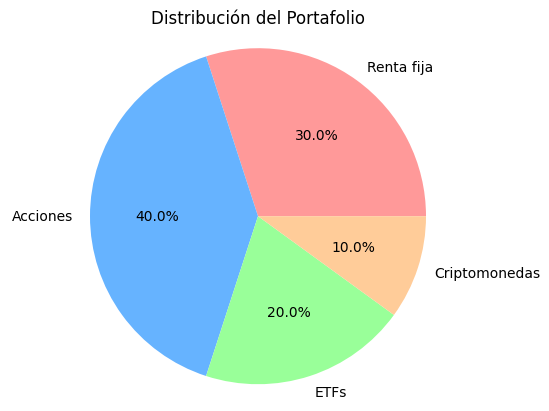


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 49.19 → Neutral
AAPL: MACD Histograma = -0.12 → Momentum bajista
----------------------------------------------------------------------
MSFT: RSI = 71.37 → Sobrecomprada, posible venta
MSFT: MACD Histograma = -1.31 → Momentum bajista
----------------------------------------------------------------------
GOOGL: RSI = 54.61 → Neutral
GOOGL: MACD Histograma = 0.25 → Momentum alcista
----------------------------------------------------------------------
TSLA: RSI = 62.78 → Neutral
TSLA: MACD Histograma = -1.31 → Momentum bajista
----------------------------------------------------------------------
NVDA: RSI = 69.29 → Neutral
NVDA: MACD Histograma = 0.26 → Momentum alcista
----------------------------------------------------------------------
META: RSI = 69.28 → Neutral
META: MACD Histograma = 1.44 → Momentum alcista
----------------------------------------------------------------------
AMZN: RSI = 60.33 → Neutral
AMZN: MACD Histograma =

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

def obtener_perfil():
    """
    Solicita el perfil de inversor.
    Opción 0 indica "volver" (es decir, salir para que el llamador
    decida en qué nivel regresar).
    Devuelve un entero (1, 2 o 3) o None.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def obtener_horizonte():
    """
    Solicita el horizonte de inversión.
    Opción 0 indica volver (regresar al nivel anterior, es decir, al perfil).
    Devuelve un entero (1, 2 o 3) o None.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def recomendar_portafolio(perfil):
    """Retorna una distribución sugerida según el perfil."""
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    """
    Permite ingresar una distribución personalizada.
    Si se pulsa 0 en alguna entrada, retorna None para indicar retroceder.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    """Muestra un gráfico de pastel con la distribución."""
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    """Muestra el desglose del capital para cada tipo de inversión."""
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza acciones usando RSI y MACD.
    La temporalidad se adapta según el horizonte:
      Corto plazo → period="3mo", interval="1d"
      Mediano plazo → period="1y", interval="1wk"
      Largo plazo → period="5y", interval="1mo"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def analizar_cripto(simbolos, horizonte):
    """
    Analiza criptomonedas usando RSI y MACD.
    La temporalidad depende del horizonte.
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def recomendar_renta_fija():
    """Muestra opciones de renta fija sugeridas."""
    print("\n🏦 Renta fija sugerida:")
    print("- Bonos USA: ETF BND o TLT")
    print("- Bonos AR en USD: AL30, GD30")

def recomendar_etfs():
    """Muestra ETFs sugeridos."""
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")

def main():
    # Bucle externo para repetir la sesión si el usuario lo desea.
    while True:
        # Paso 1: Pedir capital
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Paso 2: Bloque para obtener perfil y horizonte.
        # Se usan bucles anidados para permitir volver a la opción anterior sin reiniciar el capital.
        while True:  # Bloque de perfil y horizonte
            perfil = obtener_perfil()
            if perfil is None:
                # Opción volver en perfil: se quiere volver a ingresar capital.
                print("Volviendo al ingreso del capital...")
                break  # Salir del bloque de perfil/horizonte.

            horizonte = obtener_horizonte()
            if horizonte is None:
                # Opción volver en horizonte: regresa a la pregunta de perfil.
                print("Volviendo a la selección de perfil...")
                continue  # Repetir el bloque de perfil/horizonte.

            # Perfil y horizonte obtenidos correctamente.
            # Paso 3: Bloque de distribución.
            while True:
                print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
                print("1 - Usar distribución sugerida")
                print("2 - Crear mi propia distribución")
                print("0 - Volver")
                opcion = input("Elegí una opción (0/1/2): ")
                if opcion not in ["0", "1", "2"]:
                    print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                    continue
                if opcion == "0":
                    print("Volviendo a la selección de horizonte y perfil...")
                    break  # Salir al bloque de perfil/horizonte.
                elif opcion == "1":
                    distribucion = recomendar_portafolio(perfil)
                    break  # Distribución obtenida.
                elif opcion == "2":
                    distribucion = elegir_distribucion_personalizada()
                    if distribucion is None:
                        print("Volviendo a la selección de distribución...")
                        continue  # Repetir la pregunta de distribución.
                    else:
                        break
            if opcion == "0":
                continue  # Repetir el bloque de perfil/horizonte.
            # Si llegamos aquí, tenemos perfil, horizonte y distribución válidos.
            break  # Salir del bloque de perfil/horizonte/distribución.
        # Si perfil es None, significa que se eligió volver en la etapa del perfil y debemos reiniciar el capital.
        if perfil is None:
            continue  # Reinicia toda la sesión (vuelve a pedir capital).

        # Paso 4: Mostrar resultados y análisis.
        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija()

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs()

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        repetir = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (SI/NO): ").strip().lower()
        if repetir != 's':
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break

if __name__ == "__main__":
    main()



¿Cuánto capital tenés para invertir? $: 1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
0 - Volver
Elegí una opción (0/1/2/3): 1

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
0 - Volver
Elegí una opción (0/1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


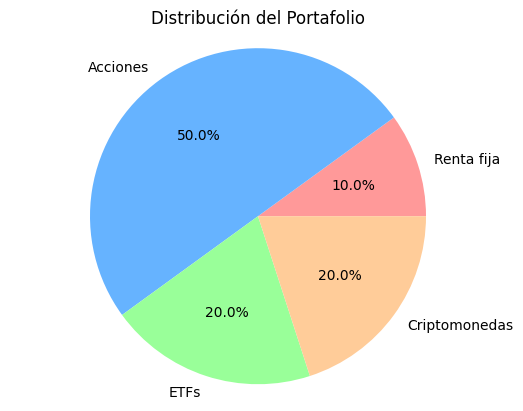


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 48.56 → Neutral
AAPL: MACD Histograma = -0.15 → Momentum bajista
----------------------------------------------------------------------
MSFT: RSI = 71.33 → Sobrecomprada, posible venta
MSFT: MACD Histograma = -1.31 → Momentum bajista
----------------------------------------------------------------------
GOOGL: RSI = 54.26 → Neutral
GOOGL: MACD Histograma = 0.23 → Momentum alcista
----------------------------------------------------------------------
TSLA: RSI = 61.80 → Neutral
TSLA: MACD Histograma = -1.50 → Momentum bajista
----------------------------------------------------------------------
NVDA: RSI = 68.89 → Neutral
NVDA: MACD Histograma = 0.23 → Momentum alcista
----------------------------------------------------------------------
META: RSI = 68.93 → Neutral
META: MACD Histograma = 1.40 → Momentum alcista
----------------------------------------------------------------------
AMZN: RSI = 59.74 → Neutral
AMZN: MACD Histograma =

KeyboardInterrupt: Interrupted by user

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

def obtener_perfil():
    """
    Solicita el perfil de inversor.
    Opción 0 indica "volver" (se regresa al nivel anterior).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def obtener_horizonte():
    """
    Solicita el horizonte de inversión.
    Opción 0 indica volver (regresa al nivel anterior, es decir, a la selección del perfil).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (regresar a la pregunta de distribución).
    Si se ingresa 0 en alguna posición, se retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción usando RSI y MACD.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: period="3mo", interval="1d"
      - Mediano plazo: period="1y", interval="1wk"
      - Largo plazo: period="5y", interval="1mo"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda usando RSI y MACD.
    La temporalidad depende del horizonte.
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def recomendar_renta_fija(horizonte):
    """
    Recomienda productos de renta fija según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo (0-12 meses):
          - Plazo Fijo en Pesos: TNA aprox. 40%-50% anual (ajustado a la inflación local).
          - Bonos y Letras del Tesoro de EEUU a corto plazo: Rendimiento anual aprox. 2%-3%.
      2 → Mediano plazo (1-3 años):
          - Bonos soberanos argentinos a mediano plazo: Rendimiento anual aprox. 15%-20%.
          - Fondos o ETFs de bonos de EEUU: Rendimiento anual aprox. 3%-4%.
      3 → Largo plazo (más de 3 años):
          - Bonos a largo plazo de EEUU (ej., bonos del Tesoro a 10-30 años): Rendimiento anual aprox. 2%-3%.
          - Bonos soberanos o corporativos argentinos a largo plazo: Rendimiento anual aprox. 20%-25%.
    """
    print("\n🏦 Recomendaciones de Renta Fija:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo (0-12 meses):")
        print(" - Plazo Fijo en Pesos: TNA aprox. 40%-50% anual (según inflación local).")
        print(" - Bonos y Letras del Tesoro de EEUU (corto plazo): Rendimiento anual aprox. 2%-3%.")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo (1-3 años):")
        print(" - Bonos soberanos argentinos a mediano plazo: Rendimiento anual aprox. 15%-20%.")
        print(" - Fondos o ETFs de bonos de EEUU: Rendimiento anual aprox. 3%-4%.")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo (más de 3 años):")
        print(" - Bonos a largo plazo de EEUU (ej., Tesoro a 10-30 años): Rendimiento anual aprox. 2%-3%.")
        print(" - Bonos soberanos/corporativos argentinos a largo plazo: Rendimiento anual aprox. 20%-25%.")
    else:
        print("Horizonte no válido para recomendaciones de renta fija.")

def recomendar_etfs():
    """Muestra ETFs sugeridos."""
    print("\n🌐 ETFs sugeridos:")
    print("- SPY (S&P 500), QQQ (Nasdaq), VTI (Total Market)")

def main():
    # Bucle externo para repetir la sesión completa si el usuario así lo decide.
    while True:
        # Paso 1: Ingreso del capital (se pide solo al inicio de la sesión)
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Paso 2: Selección de parámetros (perfil, horizonte y distribución)
        # Se usan bucles anidados para permitir volver a la opción anterior sin reiniciar el capital.
        while True:  # Bloque de perfil y horizonte
            perfil = obtener_perfil()
            if perfil is None:
                print("⤺ Regresando al ingreso del capital...")
                break  # Salir y reiniciar la sesión (volver a pedir capital)
            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Volviendo a la selección de perfil...")
                continue  # Repetir el bloque de perfil/horizonte
            # Bloque de distribución
            while True:
                print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
                print("1 - Usar distribución sugerida")
                print("2 - Crear mi propia distribución")
                print("0 - Volver")
                opcion = input("Elegí una opción (0/1/2): ")
                if opcion not in ["0", "1", "2"]:
                    print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                    continue
                if opcion == "0":
                    print("⤺ Volviendo a la selección de perfil/horizonte...")
                    break  # Rompe el bloque de distribución para volver al perfil/horizonte
                elif opcion == "1":
                    distribucion = recomendar_portafolio(perfil)
                    break  # Distribución obtenida
                elif opcion == "2":
                    distribucion = elegir_distribucion_personalizada()
                    if distribucion is None:
                        print("⤺ Volviendo a la selección de distribución...")
                        continue  # Repetir la pregunta de distribución
                    else:
                        break
            if opcion == "0":
                continue  # Regresar al bloque de perfil/horizonte
            # Si se obtuvieron perfil, horizonte y distribución válidos, salir de este bucle.
            break
        # Si se pulsó volver en la selección de perfil (perfil es None), reiniciar la sesión completa.
        if perfil is None:
            continue

        # Paso 3: Mostrar resultados y análisis
        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija(horizonte)

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs()

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        repetir = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (S/N): ").strip().lower()
        if repetir != "s":
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break

if __name__ == "__main__":
    main()



¿Cuánto capital tenés para invertir? $: 1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
0 - Volver
Elegí una opción (0/1/2/3): 3

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
0 - Volver
Elegí una opción (0/1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


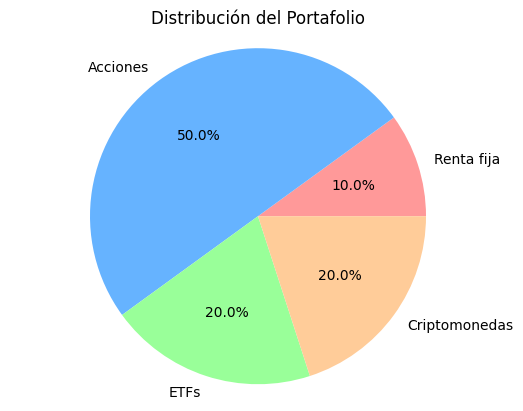


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 50.41 → Neutral
AAPL: MACD Histograma = -4.22 → Momentum bajista
----------------------------------------------------------------------
MSFT: RSI = 65.89 → Neutral
MSFT: MACD Histograma = -1.11 → Momentum bajista
----------------------------------------------------------------------
GOOGL: RSI = 54.98 → Neutral
GOOGL: MACD Histograma = -2.24 → Momentum bajista
----------------------------------------------------------------------
TSLA: RSI = 58.23 → Neutral
TSLA: MACD Histograma = 7.83 → Momentum alcista
----------------------------------------------------------------------
NVDA: RSI = 70.76 → Sobrecomprada, posible venta
NVDA: MACD Histograma = -0.86 → Momentum bajista
----------------------------------------------------------------------
META: RSI = 67.88 → Neutral
META: MACD Histograma = 4.71 → Momentum alcista
----------------------------------------------------------------------
AMZN: RSI = 59.13 → Neutral
AMZN: MACD Histograma 

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

def obtener_perfil():
    """
    Solicita el perfil de inversor.
    Opción 0 indica "volver" (se regresa al nivel anterior).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def obtener_horizonte():
    """
    Solicita el horizonte de inversión.
    Opción 0 indica volver (regresa al nivel anterior, es decir, al perfil).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (regresar a la pregunta de distribución).
    Si se ingresa 0 en alguna posición, se retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción usando RSI y MACD.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: period = "3mo", interval = "1d"
      - Mediano plazo: period = "1y", interval = "1wk"
      - Largo plazo: period = "5y", interval = "1mo"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda usando RSI y MACD.
    La temporalidad depende del horizonte.
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def recomendar_renta_fija(horizonte):
    """
    Recomienda productos de renta fija según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo (0-12 meses):
          - Plazo Fijo en Pesos: TNA aprox. 40%-50% anual.
          - Bonos y Letras del Tesoro de EEUU (corto plazo): Rendimiento anual aprox. 2%-3%.
      2 → Mediano plazo (1-3 años):
          - Bonos soberanos argentinos a mediano plazo: Rendimiento anual aprox. 15%-20%.
          - Fondos o ETFs de bonos de EEUU: Rendimiento anual aprox. 3%-4%.
      3 → Largo plazo (más de 3 años):
          - Bonos a largo plazo de EEUU (ej., Tesoro a 10-30 años): Rendimiento anual aprox. 2%-3%.
          - Bonos soberanos o corporativos argentinos a largo plazo: Rendimiento anual aprox. 20%-25%.
    """
    print("\n🏦 Recomendaciones de Renta Fija:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo (0-12 meses):")
        print(" - Plazo Fijo en Pesos: TNA aprox. 40%-50% anual (con alta inflación local).")
        print(" - Bonos y Letras del Tesoro de EEUU (corto plazo): Rendimiento anual aprox. 2%-3%.")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo (1-3 años):")
        print(" - Bonos soberanos argentinos a mediano plazo: Rendimiento anual aprox. 15%-20%.")
        print(" - Fondos o ETFs de bonos de EEUU: Rendimiento anual aprox. 3%-4%.")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo (más de 3 años):")
        print(" - Bonos a largo plazo de EEUU (ej., Tesoro a 10-30 años): Rendimiento anual aprox. 2%-3%.")
        print(" - Bonos soberanos/corporativos argentinos a largo plazo: Rendimiento anual aprox. 20%-25%.")
    else:
        print("Horizonte no válido para recomendaciones de renta fija.")

def recomendar_etfs(horizonte):
    """
    Recomienda ETFs (SPY y QQQ) en función del horizonte de inversión.

    Horizonte:
      1 → Corto plazo (0-12 meses): Los ETFs pueden ser volátiles en períodos breves, pero se recomiendan SPY y QQQ por su alta liquidez.
      2 → Mediano plazo (1-3 años): SPY y QQQ son buenas opciones para diversificar y aprovechar el crecimiento del mercado.
      3 → Largo plazo (más de 3 años): SPY y QQQ han mostrado solidez histórica y son ideales para estrategias de inversión a largo plazo.
    """
    print("\n🌐 Recomendaciones de ETFs:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo:")
        print(" - SPY (S&P 500): Alta liquidez, ideal para operar en mercados volátiles.")
        print(" - QQQ (Nasdaq): Ofrece exposición tecnológica, aunque con mayor volatilidad.")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo:")
        print(" - SPY y QQQ: Buenas opciones para diversificar y capturar crecimiento en mercados estadounidenses.")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo:")
        print(" - SPY y QQQ: Han demostrado solidez histórica y son ideales para estrategias de inversión a largo plazo.")
    else:
        print("Horizonte no válido para recomendaciones de ETFs.")

def main():
    # Bucle externo para repetir la sesión completa si el usuario así lo decide.
    while True:
        # Paso 1: Ingreso del capital
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Paso 2: Selección de parámetros (Perfil, Horizonte y Distribución)
        # Se usan bucles anidados para permitir volver un nivel sin reiniciar el capital.
        while True:  # Bloque de perfil y horizonte
            perfil = obtener_perfil()
            if perfil is None:
                print("⤺ Regresando al ingreso del capital...")
                break  # Se reinicia la sesión, se vuelve a pedir el capital
            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Volviendo a la selección de perfil...")
                continue  # Repetir el bloque de perfil/horizonte
            # Bloque de Distribución
            while True:
                print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
                print("1 - Usar distribución sugerida")
                print("2 - Crear mi propia distribución")
                print("0 - Volver")
                opcion = input("Elegí una opción (0/1/2): ")
                if opcion not in ["0", "1", "2"]:
                    print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                    continue
                if opcion == "0":
                    print("⤺ Volviendo a la selección de perfil/horizonte...")
                    break  # Sale del bloque de distribución para regresar al bloque de perfil/horizonte
                elif opcion == "1":
                    distribucion = recomendar_portafolio(perfil)
                    break
                elif opcion == "2":
                    distribucion = elegir_distribucion_personalizada()
                    if distribucion is None:
                        print("⤺ Volviendo a la selección de distribución...")
                        continue  # Repetir la pregunta de distribución
                    else:
                        break
            if opcion == "0":
                continue  # Regresar al bloque de perfil/horizonte
            # Si se han obtenido perfil, horizonte y distribución válidos, salimos.
            break
        if perfil is None:
            continue  # Reinicia toda la sesión (se vuelve a pedir el capital)

        # Paso 3: Mostrar resultados y análisis
        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija(horizonte)

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs(horizonte)

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        repetir = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (SI/NO): ").strip().lower()
        if repetir != "s":
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break

if __name__ == "__main__":
    main()



¿Cuánto capital tenés para invertir? $: 1000

¿Qué tipo de inversor sos?
1 - Conservador
2 - Moderado
3 - Agresivo
0 - Volver
Elegí una opción (0/1/2/3): 3

¿Cuál es tu horizonte de inversión?
1 - Corto plazo (0-12 meses)
2 - Mediano plazo (1-3 años)
3 - Largo plazo (más de 3 años)
0 - Volver
Elegí una opción (0/1/2/3): 3

¿Querés usar una distribución sugerida según tu perfil o crear la tuya?
1 - Usar distribución sugerida
2 - Crear mi propia distribución
0 - Volver
Elegí una opción (0/1/2): 1

📊 Distribución seleccionada:
- Renta fija: $100.00 (10%)
- Acciones: $500.00 (50%)
- ETFs: $200.00 (20%)
- Criptomonedas: $200.00 (20%)


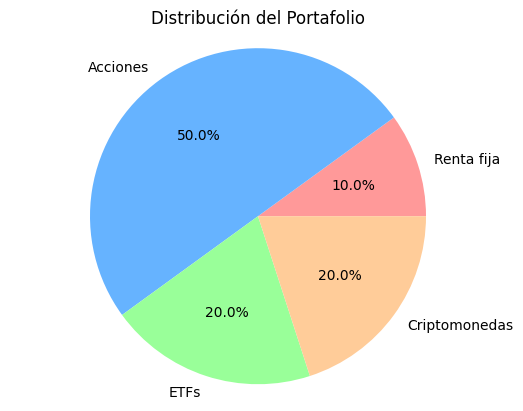


🔍 Analizando RSI y MACD de acciones...

AAPL: RSI = 50.46 → Neutral
AAPL: MACD Histograma = -4.21 → Momentum bajista
----------------------------------------------------------------------
MSFT: RSI = 66.00 → Neutral
MSFT: MACD Histograma = -1.05 → Momentum bajista
----------------------------------------------------------------------
GOOGL: RSI = 54.94 → Neutral
GOOGL: MACD Histograma = -2.25 → Momentum bajista
----------------------------------------------------------------------
TSLA: RSI = 58.27 → Neutral
TSLA: MACD Histograma = 7.86 → Momentum alcista
----------------------------------------------------------------------
NVDA: RSI = 70.83 → Sobrecomprada, posible venta
NVDA: MACD Histograma = -0.85 → Momentum bajista
----------------------------------------------------------------------
META: RSI = 67.92 → Neutral
META: MACD Histograma = 4.75 → Momentum alcista
----------------------------------------------------------------------
AMZN: RSI = 59.09 → Neutral
AMZN: MACD Histograma 

KeyboardInterrupt: Interrupted by user

In [ ]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

def obtener_perfil():
    """
    Solicita el perfil de inversor.
    Opción 0 indica "volver" (se regresa al nivel anterior).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def obtener_horizonte():
    """
    Solicita el horizonte de inversión.
    Opción 0 indica volver (regresa al nivel anterior, es decir, al perfil).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1', '2', '3']:
            return int(respuesta)
        print("Opción inválida.")

def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (regresar a la pregunta de distribución).
    Si se ingresa 0 se retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción usando RSI y MACD.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: period="3mo", interval="1d"
      - Mediano plazo: period="1y", interval="1wk"
      - Largo plazo: period="5y", interval="1mo"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda usando RSI y MACD.
    La temporalidad depende del horizonte.
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue

            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue

            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def recomendar_renta_fija(horizonte):
    """
    Recomienda productos de renta fija según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo (0-12 meses):
          - Letras del Tesoro de EEUU a corto plazo (T-Bills a 3-6 meses).
          - Depósitos/Plazos Fijos en Pesos, ofrecidos por bancos con tasas TNA en el rango del 40%-50% (según el contexto inflacionario).
          - Opciones de mercado monetario para alta liquidez.
      2 → Mediano plazo (1-3 años):
          - Treasury Notes de EEUU con vencimientos de 2 a 5 años (rendimiento aprox. 2%-3% anual).
          - Bonos soberanos argentinos como AL30 o GD30, con rendimientos en el orden del 15%-20% anual (con mayor volatilidad y riesgo cambiario).
          - Fondos de inversión en renta fija para diversificar riesgo.
      3 → Largo plazo (más de 3 años):
          - US Treasury Bonds a largo plazo (por ejemplo, a 10, 20 o 30 años), con rendimientos de 2%-3% anual y gran estabilidad.
          - Bonos soberanos o corporativos argentinos a largo plazo, como AL30, con rendimientos de 20%-25% anual.
          - Estrategias diversificadas en fondos de renta fija a largo plazo.
    """
    print("\n🏦 Recomendaciones de Renta Fija:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo (0-12 meses):")
        print(" - Invertir en Letras del Tesoro de EEUU, como T-Bills a 3-6 meses, que ofrecen alta liquidez y seguridad.")
        print(" - Considerar Depósitos o Plazos Fijos en Pesos con bancos reconocidos; las tasas nominales anuales pueden estar en el rango del 40%-50% en contextos inflacionarios.")
        print(" - Evaluar instrumentos de mercado monetario para asegurar liquidez.")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo (1-3 años):")
        print(" - Invertir en Treasury Notes de EEUU con vencimientos entre 2 y 5 años, que suelen tener rendimientos de alrededor del 2%-3% anual.")
        print(" - Explorar bonos soberanos argentinos como AL30 o GD30, con rendimientos en el rango del 15%-20% anual, aunque con mayor riesgo.")
        print(" - Considerar fondos de inversión en renta fija que diversifiquen el riesgo.")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo (más de 3 años):")
        print(" - Invertir en US Treasury Bonds a largo plazo (ej., bonos del Tesoro a 10, 20 o 30 años) que ofrecen estabilidad y rendimientos del 2%-3% anual.")
        print(" - Evaluar bonos soberanos o corporativos argentinos a largo plazo, como AL30, que pueden rendir entre 20%-25% anual, asumiendo mayores riesgos.")
        print(" - Utilizar estrategias diversificadas a través de fondos de renta fija a largo plazo.")
    else:
        print("Horizonte no válido para recomendaciones de renta fija.")

def recomendar_etfs(horizonte):
    """
    Recomienda ETFs según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo (0-12 meses): SPY y QQQ son recomendados por alta liquidez, aunque pueden presentar volatilidad en ups y downs.
      2 → Mediano plazo (1-3 años): SPY y QQQ ofrecen diversificación en el mercado estadounidense con un crecimiento sostenido.
      3 → Largo plazo (más de 3 años): Históricamente, SPY y QQQ han mostrado solidez y son ideales para estrategias de inversión a largo plazo.
    """
    print("\n🌐 Recomendaciones de ETFs:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo:")
        print(" - SPY (S&P 500): Alta liquidez y diversificación; ideal para aprovechar movimientos de mercado a corto plazo.")
        print(" - QQQ (Nasdaq): Exposición a tecnológicas con gran potencial, aunque con mayor volatilidad.")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo:")
        print(" - SPY y QQQ: Combinadas, ofrecen una vía para capturar el crecimiento del mercado estadounidense con diversificación.")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo:")
        print(" - SPY y QQQ: Tienen un historial probado de solidez y crecimiento, recomendados para estrategias de inversión a largo plazo.")
    else:
        print("Horizonte no válido para recomendaciones de ETFs.")

def main():
    # Bucle externo para repetir la sesión completa si el usuario así lo decide.
    while True:
        # Paso 1: Ingreso del capital
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Paso 2: Selección de parámetros (Perfil, Horizonte y Distribución)
        # Se usan bucles anidados para permitir volver un nivel sin reiniciar el capital.
        while True:  # Bloque de perfil y horizonte
            perfil = obtener_perfil()
            if perfil is None:
                print("⤺ Regresando al ingreso del capital...")
                break  # Se vuelve a pedir el capital reiniciando la sesión
            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Volviendo a la selección de perfil...")
                continue  # Repetir el bloque de perfil/horizonte
            # Bloque de Distribución
            while True:
                print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
                print("1 - Usar distribución sugerida")
                print("2 - Crear mi propia distribución")
                print("0 - Volver")
                opcion = input("Elegí una opción (0/1/2): ")
                if opcion not in ["0", "1", "2"]:
                    print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                    continue
                if opcion == "0":
                    print("⤺ Volviendo a la selección de perfil/horizonte...")
                    break  # Sale del bloque de distribución para regresar al bloque de perfil/horizonte
                elif opcion == "1":
                    distribucion = recomendar_portafolio(perfil)
                    break
                elif opcion == "2":
                    distribucion = elegir_distribucion_personalizada()
                    if distribucion is None:
                        print("⤺ Volviendo a la selección de distribución...")
                        continue  # Repetir la pregunta de distribución
                    else:
                        break
            if opcion == "0":
                continue  # Regresar al bloque de perfil/horizonte
            # Si se han obtenido perfil, horizonte y distribución válidos, salimos.
            break
        if perfil is None:
            continue  # Reinicia toda la sesión (se vuelve a pedir el capital)

        # Paso 3: Mostrar resultados y análisis
        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija(horizonte)

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs(horizonte)

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        repetir = input("\n¿Te gustó el resultado? ¿Quieres hacerlo de nuevo? (S/N): ").strip().lower()
        if repetir != "s":
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break

if __name__ == "__main__":
    main()


In [ ]:
print("------ 💵📈 BIENVENIDO A TU ASESOR FINANCIERO PERSONAL EN PYTHON 📈💵 ------")


def obtener_perfil():
    """
    Solicita el perfil de inversor.
    Se muestran las opciones:
      1 - Conservador
      2 - Moderado
      3 - Agresivo
      0 - Volver
    Además, se muestra el mensaje: “Si no sabes qué tipo de inversor sos, podés hacer un test del Inversor acá: <URL>”
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    print("Si no sabes qué tipo de Inversor eres, podés hacer un TEST DEL INVERSOR aquí: https://iol.invertironline.com/User/test-del-inversor?_gl=1*1lhem7l*_gcl_au*MjAxNjkyMjc5NS4xNzQ4OTc3OTM3*_ga*MTY2NzgwMzY4OC4xNzQ4OTc3OTM3*_ga_3ZJ55WFL39*czE3NDg5Nzc5MzckbzEkZzEkdDE3NDg5NzgwMjUkajQxJGwwJGgxNjExNjAyNDY1")
    print("")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1','2','3']:
            return int(respuesta)
        print("Opción inválida.")

def obtener_horizonte():
    """
    Solicita el horizonte de inversión.
    Opción 0 indica volver (regresa al nivel anterior, es decir, a la selección del perfil).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1','2','3']:
            return int(respuesta)
        print("Opción inválida.")

def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (regresar a la pregunta de distribución).
    Si se ingresa 0 se retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o 0 para volver): ")
            if val.strip() == "0":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción usando RSI y MACD.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: period="3mo", interval="1d"
      - Mediano plazo: period="1y", interval="1wk"
      - Largo plazo: period="5y", interval="1mo"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue
            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue
            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda usando RSI y MACD.
    La temporalidad depende del horizonte.
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"
    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue
            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")
            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue
            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")
            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue
            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]
            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")
            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def recomendar_renta_fija(horizonte):
    """
    Recomienda productos de renta fija según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo (0-12 meses):
          - US Treasury:
              • T-Bill a 3 meses: Rendimiento anual aprox. 2.5%
              • T-Bill a 6 meses: Rendimiento anual aprox. 2.8%
          - Argentina:
              • Letras del Tesoro: Rendimiento anual aprox. 10%-12%
              • Plazo Fijo en Banco Nación (30 días): TNA aprox. 45%-50%
      2 → Mediano plazo (1-3 años):
          - US Treasury:
              • Treasury Note a 2 años: Rendimiento anual aprox. 2.5%
              • Treasury Note a 5 años: Rendimiento anual aprox. 3%
          - Argentina:
              • Bonos soberanos (Ej: AL30 o GD30): Rendimiento anual aprox. 15%-20%
              • Plazo Fijo en Banco Galicia (90 días): TNA aprox. 55%-60%
      3 → Largo plazo (más de 3 años):
          - US Treasury:
              • Treasury Bond a 10 años: Rendimiento anual aprox. 2.5%
              • Treasury Bond a 20 años: Rendimiento anual aprox. 2.8%
              • Treasury Bond a 30 años: Rendimiento anual aprox. 3%
          - Argentina:
              • Bonos soberanos/corporativos (Ej: AL30): Rendimiento anual aprox. 20%-25%
              • Plazo Fijo en Banco Santander Río (180 días): TNA aprox. 60%-70%
    """
    print("\n🏦 Recomendaciones de Renta Fija:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo (0-12 meses):")
        print(" US Treasury:")
        print("  - T-Bill a 3 meses: Rendimiento anual aprox. 2.5%")
        print("  - T-Bill a 6 meses: Rendimiento anual aprox. 2.8%")
        print(" Argentina:")
        print("  - Letras del Tesoro: Rendimiento anual aprox. 10%-12%")
        print("  - Plazo Fijo en Banco Nación (30 días): TNA aprox. 45%-50%")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo (1-3 años):")
        print(" US Treasury:")
        print("  - Treasury Note a 2 años: Rendimiento anual aprox. 2.5%")
        print("  - Treasury Note a 5 años: Rendimiento anual aprox. 3%")
        print(" Argentina:")
        print("  - Bonos soberanos (Ej: AL30 o GD30): Rendimiento anual aprox. 15%-20%")
        print("  - Plazo Fijo en Banco Galicia (90 días): TNA aprox. 55%-60%")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo (más de 3 años):")
        print(" US Treasury:")
        print("  - Treasury Bond a 10 años: Rendimiento anual aprox. 2.5%")
        print("  - Treasury Bond a 20 años: Rendimiento anual aprox. 2.8%")
        print("  - Treasury Bond a 30 años: Rendimiento anual aprox. 3%")
        print(" Argentina:")
        print("  - Bonos soberanos/corporativos (Ej: AL30): Rendimiento anual aprox. 20%-25%")
        print("  - Plazo Fijo en Banco Santander Río (180 días): TNA aprox. 60%-70%")
    else:
        print("Horizonte no válido para recomendaciones de renta fija.")

def recomendar_etfs(horizonte):
    """
    Recomienda ETFs (SPY y QQQ) según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo: Alta liquidez, aunque mayor volatilidad.
      2 → Mediano plazo: Buenas para capturar crecimiento.
      3 → Largo plazo: Históricamente sólidas para estrategias a largo plazo.
    """
    print("\n🌐 Recomendaciones de ETFs:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo:")
        print(" - SPY (S&P 500): Alta liquidez y diversificación; útil en movimientos de mercado a corto plazo.")
        print(" - QQQ (Nasdaq): Ofrece exposición a tecnológicas con mayor volatilidad.")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo:")
        print(" - SPY y QQQ: Permiten capturar el crecimiento del mercado estadounidense con buena diversificación.")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo:")
        print(" - SPY y QQQ: Tienen un historial probado de solidez y crecimiento, ideales para inversión a largo plazo.")
    else:
        print("Horizonte no válido para recomendaciones de ETFs.")

def main():
    # Bucle externo para repetir la sesión completa si el usuario así lo decide.
    while True:
        # Paso 1: Ingreso del capital
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Paso 2: Selección de parámetros (Perfil, Horizonte y Distribución)
        while True:  # Bloque de perfil y horizonte
            perfil = obtener_perfil()
            if perfil is None:
                print("⤺ Regresando al ingreso del capital...")
                break  # Se reinicia la sesión; volverá a pedir el capital
            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Volviendo a la selección de perfil...")
                continue  # Repetir el bloque de perfil/horizonte
            # Bloque de Distribución
            while True:
                print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
                print("1 - Usar distribución sugerida")
                print("2 - Crear mi propia distribución")
                print("0 - Volver")
                opcion = input("Elegí una opción (0/1/2): ")
                if opcion not in ["0", "1", "2"]:
                    print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                    continue
                if opcion == "0":
                    print("⤺ Volviendo a la selección de perfil/horizonte...")
                    break  # Sale del bloque de distribución para regresar al perfil/horizonte
                elif opcion == "1":
                    distribucion = recomendar_portafolio(perfil)
                    break
                elif opcion == "2":
                    distribucion = elegir_distribucion_personalizada()
                    if distribucion is None:
                        print("⤺ Volviendo a la selección de distribución...")
                        continue  # Repetir la pregunta de distribución
                    else:
                        break
            if opcion == "0":
                continue  # Regresar al bloque de perfil/horizonte
            break  # Se obtuvieron perfil, horizonte y distribución válidos
        if perfil is None:
            continue  # Reinicia toda la sesión (se vuelve a pedir el capital)

        # Paso 3: Mostrar resultados y análisis
        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija(horizonte)

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs(horizonte)

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        repetir = input("\n¿Quieres hacerlo de nuevo? (SI/NO): ").strip().lower()
        if repetir != "s":
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break

if __name__ == "__main__":
  main()

import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
print(" -------💸📈 BIENVENIDO A TU ASESOR FINANCIERO PERSONAL EN PYTHON 📈💸------- ")

def obtener_perfil():
    """
    Solicita el perfil de inversor.
    Se muestran las opciones:
      1 - Conservador
      2 - Moderado
      3 - Agresivo
      0 - Volver
    Además, se muestra el mensaje: “Si no sabes qué tipo de inversor sos, podés hacer un test del Inversor acá: <URL>”
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Qué tipo de inversor sos?")
    print("1 - Conservador")
    print("2 - Moderado")
    print("3 - Agresivo")
    print("0 - Volver")
    print("Si no sabes qué tipo de Inversor eres, podés hacer un TEST DEL INVERSOR aquí: https://iol.invertironline.com/User/test-del-inversor?_gl=1*1lhem7l*_gcl_au*MjAxNjkyMjc5NS4xNzQ4OTc3OTM3*_ga*MTY2NzgwMzY4OC4xNzQ4OTc3OTM3*_ga_3ZJ55WFL39*czE3NDg5Nzc5MzckbzEkZzEkdDE3NDg5NzgwMjUkajQxJGwwJGgxNjExNjAyNDY1")
    print("")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1','2','3']:
            return int(respuesta)
        print("Opción inválida.")

def obtener_horizonte():
    """
    Solicita el horizonte de inversión.
    Opción 0 indica volver (regresa al nivel anterior, es decir, a la selección del perfil).
    Devuelve:
      - Un entero (1, 2 o 3) si la elección es válida.
      - None si se pulsa 0.
    """
    print("\n¿Cuál es tu horizonte de inversión?")
    print("1 - Corto plazo (0-12 meses)")
    print("2 - Mediano plazo (1-3 años)")
    print("3 - Largo plazo (más de 3 años)")
    print("0 - Volver")
    while True:
        respuesta = input("Elegí una opción (0/1/2/3): ")
        if respuesta == "0":
            return None
        if respuesta in ['1','2','3']:
            return int(respuesta)
        print("Opción inválida.")

def recomendar_portafolio(perfil):
    """
    Retorna una distribución sugerida según el perfil del inversor.
    """
    if perfil == 1:
        return {'Renta fija': 60, 'Acciones': 20, 'ETFs': 10, 'Criptomonedas': 10}
    elif perfil == 2:
        return {'Renta fija': 30, 'Acciones': 40, 'ETFs': 20, 'Criptomonedas': 10}
    else:
        return {'Renta fija': 10, 'Acciones': 50, 'ETFs': 20, 'Criptomonedas': 20}

def elegir_distribucion_personalizada():
    """
    Permite al usuario ingresar una distribución personalizada.
    Los porcentajes deben sumar 100.
    En cada entrada se ofrece la opción "0" para volver (regresar a la pregunta de distribución).
    Si se ingresa 0 se retorna None.
    """
    print("\n🔧 Ingresá tu distribución personalizada (los porcentajes deben sumar 100):")
    tipos = ['Renta fija', 'Acciones', 'ETFs', 'Criptomonedas']
    distribucion = {}
    total = 0
    for tipo in tipos:
        while True:
            val = input(f"% a invertir en {tipo} (o SALIR para volver): ").upper()

            if val.strip() == "SALIR":
                return None
            try:
                porcentaje = float(val)
            except ValueError:
                print("Ingresá un número válido.")
                continue
            if 0 <= porcentaje <= 100:
                distribucion[tipo] = porcentaje
                total += porcentaje
                break
            else:
                print("Por favor, ingresá un valor entre 0 y 100.")
    if round(total, 2) != 100.0:
        print("\n❌ Los porcentajes no suman 100. Volvé a intentarlo.")
        return elegir_distribucion_personalizada()
    return distribucion

def mostrar_grafico(distribucion):
    """
    Muestra un gráfico de pastel con la distribución del portafolio.
    """
    labels = distribucion.keys()
    sizes = distribucion.values()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.axis('equal')
    plt.title("Distribución del Portafolio")
    plt.show()

def mostrar_desglose(distribucion, capital):
    """
    Muestra el desglose del capital para cada tipo de inversión.
    """
    print("\n📊 Distribución seleccionada:")
    for tipo, porcentaje in distribucion.items():
        monto = capital * porcentaje / 100
        print(f"- {tipo}: ${monto:.2f} ({porcentaje}%)")

def analizar_acciones_rsi_macd(simbolos, horizonte):
    """
    Analiza cada acción usando RSI y MACD.
    La temporalidad se adapta según el horizonte:
      - Corto plazo: period="3mo", interval="1d"
      - Mediano plazo: period="1y", interval="1wk"
      - Largo plazo: period="5y", interval="1mo"
    """
    print("\n🔍 Analizando RSI y MACD de acciones...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"

    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue

            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue
            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")

            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue

            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue
            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")

            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue

            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]

            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")

            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def analizar_cripto(simbolos, horizonte):
    """
    Analiza cada criptomoneda usando RSI y MACD.
    La temporalidad depende del horizonte.
    """
    print("\n🔍 Analizando RSI y MACD de criptomonedas...\n")
    if horizonte == 1:
        period, interval = "3mo", "1d"
    elif horizonte == 2:
        period, interval = "1y", "1wk"
    elif horizonte == 3:
        period, interval = "5y", "1mo"
    else:
        period, interval = "3mo", "1d"
    lower_threshold = 30
    upper_threshold = 70

    for ticker in simbolos:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"⚠️ {ticker}: Sin datos disponibles.")
                continue
            if isinstance(data.columns, pd.MultiIndex):
                if "Close" in data.columns.get_level_values(1):
                    data.columns = data.columns.get_level_values(1)
                else:
                    data.columns = ['_'.join(map(str, col)).strip('_') for col in data.columns.values]
            data.ta.rsi(length=14, append=True)
            if "RSI_14" not in data.columns:
                print(f"⚠️ {ticker}: RSI no disponible.")
                continue
            rsi = data["RSI_14"].iloc[-1]
            if rsi <= lower_threshold:
                rsi_estado = "\033[92mSobrevendida, posible compra\033[0m"
            elif rsi >= upper_threshold:
                rsi_estado = "\033[91mSobrecomprada, posible venta\033[0m"
            else:
                rsi_estado = "\033[93mNeutral\033[0m"
            print(f"{ticker}: RSI = {rsi:.2f} → {rsi_estado}")
            if "Close" not in data.columns:
                found = False
                for col in data.columns:
                    if "close" in col.lower():
                        data["Close"] = data[col]
                        found = True
                        break
                if not found:
                    print(f"⚠️ {ticker}: La columna 'Close' no se encontró.")
                    print("-" * 70)
                    continue
            macd = ta.macd(data["Close"])
            data = data.join(macd)
            req_cols = ["MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9"]
            last_macd = data[req_cols].iloc[-1]
            if last_macd.isna().any():
                print(f"⚠️ {ticker}: MACD no disponible.")
                print("-" * 70)
                continue
            macdh = last_macd["MACDh_12_26_9"]
            if macdh > 0:
                histo_status = "\033[92mMomentum alcista\033[0m"
            elif macdh < 0:
                histo_status = "\033[91mMomentum bajista\033[0m"
            else:
                histo_status = "\033[93mSin dirección clara\033[0m"
            print(f"{ticker}: MACD Histograma = {macdh:.2f} → {histo_status}")
            try:
                last2 = data[req_cols].iloc[-2]
            except IndexError:
                print(f"⚠️ {ticker}: No hay suficientes datos para evaluar cruces.")
                print("-" * 70)
                continue
            macd_curr = last_macd["MACD_12_26_9"]
            signal_curr = last_macd["MACDs_12_26_9"]
            macd_prev = last2["MACD_12_26_9"]
            signal_prev = last2["MACDs_12_26_9"]
            if macd_prev < signal_prev and macd_curr > signal_curr:
                print(f"📈 {ticker}: Cruce alcista detectado (compra)")
            elif macd_prev > signal_prev and macd_curr < signal_curr:
                print(f"📉 {ticker}: Cruce bajista detectado (venta)")
            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar MACD de {ticker}: {e}")

def recomendar_renta_fija(horizonte):
    """
    Recomienda productos de renta fija según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo (0-12 meses):
          - US Treasury:
              • T-Bill a 3 meses: Rendimiento anual aprox. 2.5%
              • T-Bill a 6 meses: Rendimiento anual aprox. 2.8%
          - Argentina:
              • Letras del Tesoro: Rendimiento anual aprox. 10%-12%
              • Plazo Fijo en Banco Nación (30 días): TNA aprox. 45%-50%
      2 → Mediano plazo (1-3 años):
          - US Treasury:
              • Treasury Note a 2 años: Rendimiento anual aprox. 2.5%
              • Treasury Note a 5 años: Rendimiento anual aprox. 3%
          - Argentina:
              • Bonos soberanos (Ej: AL30 o GD30): Rendimiento anual aprox. 15%-20%
              • Plazo Fijo en Banco Galicia (90 días): TNA aprox. 55%-60%
      3 → Largo plazo (más de 3 años):
          - US Treasury:
              • Treasury Bond a 10 años: Rendimiento anual aprox. 2.5%
              • Treasury Bond a 20 años: Rendimiento anual aprox. 2.8%
              • Treasury Bond a 30 años: Rendimiento anual aprox. 3%
          - Argentina:
              • Bonos soberanos/corporativos (Ej: AL30): Rendimiento anual aprox. 20%-25%
              • Plazo Fijo en Banco Santander Río (180 días): TNA aprox. 60%-70%
    """
    print("\n🏦 Recomendaciones de Renta Fija:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo (0-12 meses):")
        print(" US Treasury:")
        print("  - T-Bill a 3 meses: Rendimiento anual aprox. 2.5%")
        print("  - T-Bill a 6 meses: Rendimiento anual aprox. 2.8%")
        print(" Argentina:")
        print("  - Letras del Tesoro: Rendimiento anual aprox. 10%-12%")
        print("  - Plazo Fijo en Banco Nación (30 días): TNA aprox. 45%-50%")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo (1-3 años):")
        print(" US Treasury:")
        print("  - Treasury Note a 2 años: Rendimiento anual aprox. 2.5%")
        print("  - Treasury Note a 5 años: Rendimiento anual aprox. 3%")
        print(" Argentina:")
        print("  - Bonos soberanos (Ej: AL30 o GD30): Rendimiento anual aprox. 15%-20%")
        print("  - Plazo Fijo en Banco Galicia (90 días): TNA aprox. 55%-60%")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo (más de 3 años):")
        print(" US Treasury:")
        print("  - Treasury Bond a 10 años: Rendimiento anual aprox. 2.5%")
        print("  - Treasury Bond a 20 años: Rendimiento anual aprox. 2.8%")
        print("  - Treasury Bond a 30 años: Rendimiento anual aprox. 3%")
        print(" Argentina:")
        print("  - Bonos soberanos/corporativos (Ej: AL30): Rendimiento anual aprox. 20%-25%")
        print("  - Plazo Fijo en Banco Santander Río (180 días): TNA aprox. 60%-70%")
    else:
        print("Horizonte no válido para recomendaciones de renta fija.")

def recomendar_etfs(horizonte):
    """
    Recomienda ETFs (SPY y QQQ) según el horizonte de inversión.

    Horizonte:
      1 → Corto plazo: Alta liquidez, aunque mayor volatilidad.
      2 → Mediano plazo: Buenas para capturar crecimiento.
      3 → Largo plazo: Históricamente sólidas para estrategias a largo plazo.
    """
    print("\n🌐 Recomendaciones de ETFs:")
    if horizonte == 1:
        print("Para un horizonte de corto plazo:")
        print(" - SPY (S&P 500): Alta liquidez y diversificación; útil en movimientos de mercado a corto plazo.")
        print(" - QQQ (Nasdaq): Ofrece exposición a tecnológicas con mayor volatilidad.")
    elif horizonte == 2:
        print("Para un horizonte de mediano plazo:")
        print(" - SPY y QQQ: Permiten capturar el crecimiento del mercado estadounidense con buena diversificación.")
    elif horizonte == 3:
        print("Para un horizonte de largo plazo:")
        print(" - SPY y QQQ: Tienen un historial probado de solidez y crecimiento, ideales para inversión a largo plazo.")
    else:
        print("Horizonte no válido para recomendaciones de ETFs.")

def main():
    # Bucle externo para repetir la sesión completa si el usuario así lo decide.
    while True:
        # Paso 1: Ingreso del capital
        while True:
            capital_input = input("\n¿Cuánto capital tenés para invertir? $: ")
            try:
                capital = float(capital_input)
                if capital > 0:
                    break
                else:
                    print("El capital debe ser mayor a 0.")
            except ValueError:
                print("Ingresá un número válido.")

        # Paso 2: Selección de parámetros (Perfil, Horizonte y Distribución)
        while True:  # Bloque de perfil y horizonte
            perfil = obtener_perfil()
            if perfil is None:
                print("⤺ Regresando al ingreso del capital...")
                break  # Se reinicia la sesión; volverá a pedir el capital
            horizonte = obtener_horizonte()
            if horizonte is None:
                print("⤺ Volviendo a la selección de perfil...")
                continue  # Repetir el bloque de perfil/horizonte
            # Bloque de Distribución
            while True:
                print("\n¿Querés usar una distribución sugerida según tu perfil o crear la tuya?")
                print("1 - Usar distribución sugerida")
                print("2 - Crear mi propia distribución")
                print("0 - Volver")
                opcion = input("Elegí una opción (0/1/2): ")
                if opcion not in ["0", "1", "2"]:
                    print("Opción inválida. Por favor, ingrese 0, 1 o 2.")
                    continue
                if opcion == "0":
                    print("⤺ Volviendo a la selección de perfil/horizonte...")
                    break  # Sale del bloque de distribución para regresar al perfil/horizonte
                elif opcion == "1":
                    distribucion = recomendar_portafolio(perfil)
                    break
                elif opcion == "2":
                    distribucion = elegir_distribucion_personalizada()
                    if distribucion is None:
                        print("⤺ Volviendo a la selección de distribución...")
                        continue  # Repetir la pregunta de distribución
                    else:
                        break
            if opcion == "0":
                continue  # Regresar al bloque de perfil/horizonte
            break  # Se obtuvieron perfil, horizonte y distribución válidos
        if perfil is None:
            continue  # Reinicia toda la sesión (se vuelve a pedir el capital)

        # Paso 3: Mostrar resultados y análisis
        mostrar_desglose(distribucion, capital)
        mostrar_grafico(distribucion)

        if distribucion.get("Acciones", 0) > 0:
            accionistas = [
                "AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "META", "AMZN",
                "AMD", "NFLX", "DIS", "INTC", "CRM", "PYPL", "BA", "NKE",
                "UBER", "BABA", "ORCL", "IBM"
            ]
            analizar_acciones_rsi_macd(accionistas, horizonte)

        if distribucion.get("Criptomonedas", 0) > 0:
            print("\n🪙 Criptomonedas sugeridas:")
            crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]
            analizar_cripto(crypto_tickers, horizonte)

        if distribucion.get("Renta fija", 0) > 0:
            recomendar_renta_fija(horizonte)

        if distribucion.get("ETFs", 0) > 0:
            recomendar_etfs(horizonte)

        print("\n✅ Gracias por usar el asistente. ¡Mucho éxito con tus inversiones!")
        repetir = input("\n¿Quieres hacerlo de nuevo? (SI/NO): ").strip().lower()
        if repetir != "si":
            print("\nGracias por utilizar el asistente. ¡Hasta la próxima!")
            break

if __name__ == "__main__":
    main()

import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd


 -------💸📈 BIENVENIDO A TU ASESOR FINANCIERO PERSONAL EN PYTHON 📈💸------- 
